In [4]:
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip

from matplotlib.colors import LogNorm
import matplotlib.pylab as plt
import cmocean

import numpy as np
import pandas as pd
import os
import types

from scipy.signal import medfilt

import beast
import beast.tools.beast_settings
from beast.tools import (
    beast_settings,
    create_background_density_map)
from beast.tools.density_map import BinnedDensityMap
from beast.plotting import plot_mag_hist
from astropy.table import Table
from beast.plotting import plot_toothpick_details
import beast.plotting.plot_toothpick_details
import importlib
importlib.reload(plot_toothpick_details)

<module 'beast.plotting.plot_toothpick_details' from '/Users/pyanchulova/Documents/beast/beast/plotting/plot_toothpick_details.py'>

In [4]:
# plt.set_cmap('winter_r')
fontsize = 13
font = {"size": fontsize}
plt.rc("font", **font)

## Array for grid of results; only set at the beginning of a param grid search

In [6]:
grid_results = []
global_maximum = []
npsrcden = []
pltsrcden = []

In [5]:
# Number of combinations of parameters; needs to be updated every time
trials = 1
plot=True

# Do we want to generate a new catalog containing the cut sources which are flagged with CUT_FLAG=1?
add_cutflag=True
savefig=True

## Quality thresholds

In [10]:
crowd_th = 0.3 # gst: 2 #0.75
sharp_th = 0.15 #0.2 
round_th = 0.6 # gst: 1 #2
bright_th = 20 # mag

## Get observations catalog 

In [5]:
# target = 'SMC-3956ne-9632' # SMC-6
target = 'SMC-3370ne-13459' # SMC-20
inDir = '/Users/pyanchulova/Documents/scylla/'
outDir = '/Users/pyanchulova/Documents/scylla/'
if not os.path.exists(outDir):
    os.mkdir(outDir)

In [11]:
stfile = inDir + '15891_%s.st.fits' % target
gstfile = inDir + '15891_%s.gst.fits' % target

stcat = fits.getdata(stfile)
gstcat = fits.getdata(gstfile)

# confirm catalog length
print('st/gst catalogs for %s have %s/%s entries' % (target, len(stcat['RA']), len(gstcat['RA'])))
t = Table.read(stfile)
filters = [x.split('_')[0] for x in t.colnames if "VEGA" in x]
print(filters)

st/gst catalogs for SMC-3370ne-13459 have 71877/71877 entries
['F110W', 'F160W', 'F275W', 'F336W', 'F475W', 'F814W']


## Get ASTs catalog

In [21]:
get_asts=True
if get_asts:
    scylla_st_asts = inDir + '15891_' + target + '.st.fake.fits'
    print("ASTs catalog:", scylla_st_asts)

ASTs catalog: /Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459.st.fake.fits


### A check on F336W_IN (~9000 NaNs)

In [12]:
# Only an issue if reading in fake stars catalog
# This may be taken care of in the second section which deals with the fake stars catalog
fake_cat=False

if fake_cat:
    f336nan = np.isnan(stcat['F336W_IN'])
    print('N (F336W_IN = NaN)', len(np.where(f336nan == True)[0]))

# Designate these with 99s farther down when recording the new catalog

In [13]:
t.colnames
if 'RA' in t.colnames:
    ra_key = "RA"
    dec_key = "DEC"
else:
    ra_key = "RA_J2000"
    dec_key = "DEC_J2000"

In [14]:
two_key = ['F475W', 'F814W']

## Test quality cuts

In [15]:
print('Total # sources in st cat:', len(stcat))

# Stars that did not pass the cuts in each filter have mag=99.999 
print('Remaining sources:')
default_cut = (gstcat[two_key[0]+'_VEGA'] < 99) & \
              (gstcat[two_key[1]+'_VEGA'] < 99)
print('default gst cut (has err and snr cuts):', len(gstcat[default_cut]))

# Cut on DOLPHOT flag. Keep only sources with flag=0 or 2
flag_cut = ((stcat[two_key[0]+'_FLAG'] == 0) | (stcat[two_key[0]+'_FLAG'] == 2)) & \
           ((stcat[two_key[1]+'_FLAG'] == 0) | (stcat[two_key[1]+'_FLAG'] == 2))
print('FLAG remaining:', len(stcat[flag_cut]))

# Cut on RATE. Keep only sources with rate != 0.0 in ALL bands
rate_cut = np.all([stcat[x+'_RATE']!=0 for x in filters], axis=0).tolist()
print('RATE remaining:', len(stcat[rate_cut]))

# Cut on CROWD. Keep only sources with CROWD < crowd_threshold (GST default=2.25)
crowd_cut = (stcat[two_key[0]+'_CROWD'] < crowd_th) & \
            (stcat[two_key[1]+'_CROWD'] < crowd_th)
print('CROWD remaining:', len(stcat[crowd_cut]))

# Cut on SHARP. Keep only sources with sharp**2 < sharp_threshold (GST default=0.2)
sharp_cut = (stcat[two_key[0]+'_SHARP']**2 < sharp_th) & \
            (stcat[two_key[1]+'_SHARP']**2 < sharp_th)
print('SHARP remaining:', len(stcat[sharp_cut]))

# Cut on ROUND. Keep only sources with round < round_threshold (no ROUND cut in the default cut)
round_cut = (stcat[two_key[0]+'_ROUND'] < round_th) & \
            (stcat[two_key[1]+'_ROUND'] < round_th)
print('ROUND remaining:', len(stcat[round_cut]))

# Cut on bright sources. Keep sources with F475W_VEGA <= bright_threshold
bright_cut = (stcat[two_key[0]+'_VEGA'] <= bright_th)
print('Bright stars (f475w_vega <= %s): %s' % (bright_th, len(stcat[bright_cut])))

qual_cut = crowd_cut & sharp_cut & round_cut & flag_cut
my_cut = crowd_cut & sharp_cut & round_cut & flag_cut & rate_cut | bright_cut
len_my_cut = len(stcat[~my_cut])
print('Total sources removed by quality cuts:', len_my_cut)

my_cut_no_bright = crowd_cut & sharp_cut & round_cut & flag_cut & rate_cut
len_my_cut_no_bright = len(stcat[~my_cut_no_bright])
print('Total BRIGHT sources removed by quality cuts:', len_my_cut_no_bright - len_my_cut)

print('My cut (# of srcs remaining): %s (%s %%)' % (len(stcat[my_cut]), np.around(len(stcat[my_cut]) / len(stcat), decimals=2)*100))

Total # sources in st cat: 71877
Remaining sources:
default gst cut (has err and snr cuts): 25391
FLAG remaining: 71740
RATE remaining: 46301
CROWD remaining: 42331
SHARP remaining: 45981
ROUND remaining: 52720
Bright stars (f475w_vega <= 20): 296
Total sources removed by quality cuts: 53794
Total BRIGHT sources removed by quality cuts: 84
My cut (# of srcs remaining): 18083 (25.0 %)


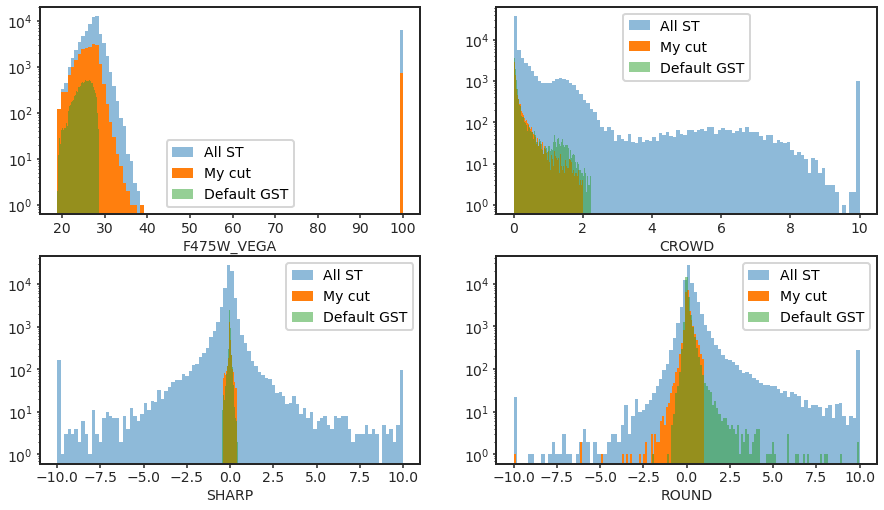

In [69]:
if plot:
    plt.figure(figsize=(15,13))

    plt.subplot(321)
    h = plt.hist(stcat[two_key[0]+'_VEGA'], bins=100, alpha=0.5, log=True)
    h = plt.hist(stcat[two_key[0]+'_VEGA'][my_cut], bins=100)
    h = plt.hist(gstcat[two_key[0]+'_VEGA'][default_cut], bins=100, alpha=0.5)
    plt.xlabel(two_key[0]+'_VEGA')
    plt.legend(['All ST','My cut','Default GST'])

    plt.subplot(322)
    h = plt.hist(stcat[two_key[0]+'_CROWD'], bins=100, alpha=0.5, log=True)
    h = plt.hist(stcat[two_key[0]+'_CROWD'][my_cut], bins=100)
    h = plt.hist(gstcat[two_key[0]+'_CROWD'][default_cut], bins=100, alpha=0.5)
    plt.xlabel('CROWD')
    plt.legend(['All ST','My cut','Default GST'])

    plt.subplot(323)
    h = plt.hist(stcat[two_key[0]+'_SHARP'], bins=100, alpha=0.5, log=True)
    h = plt.hist(stcat[two_key[0]+'_SHARP'][my_cut], bins=100, log=True)
    h = plt.hist(gstcat[two_key[0]+'_SHARP'][default_cut], bins=100, alpha=0.5)
    plt.xlabel('SHARP')
    plt.legend(['All ST','My cut','Default GST'])

    plt.subplot(324)
    h = plt.hist(stcat[two_key[0]+'_ROUND'], bins=100, alpha=0.5, log=True)
    h = plt.hist(stcat[two_key[0]+'_ROUND'][my_cut], bins=100, log=True)
    h = plt.hist(gstcat[two_key[0]+'_ROUND'][default_cut], bins=100, alpha=0.5)
    plt.xlabel('ROUND')
    plt.legend(['All ST','My cut','Default GST'])

    plt.savefig(outDir + 'histograms_crwd_%s_sh_%s_rnd_%s.png' % (crowd_th, sharp_th, round_th))


## Plot default gst cuts

<Figure size 432x288 with 0 Axes>

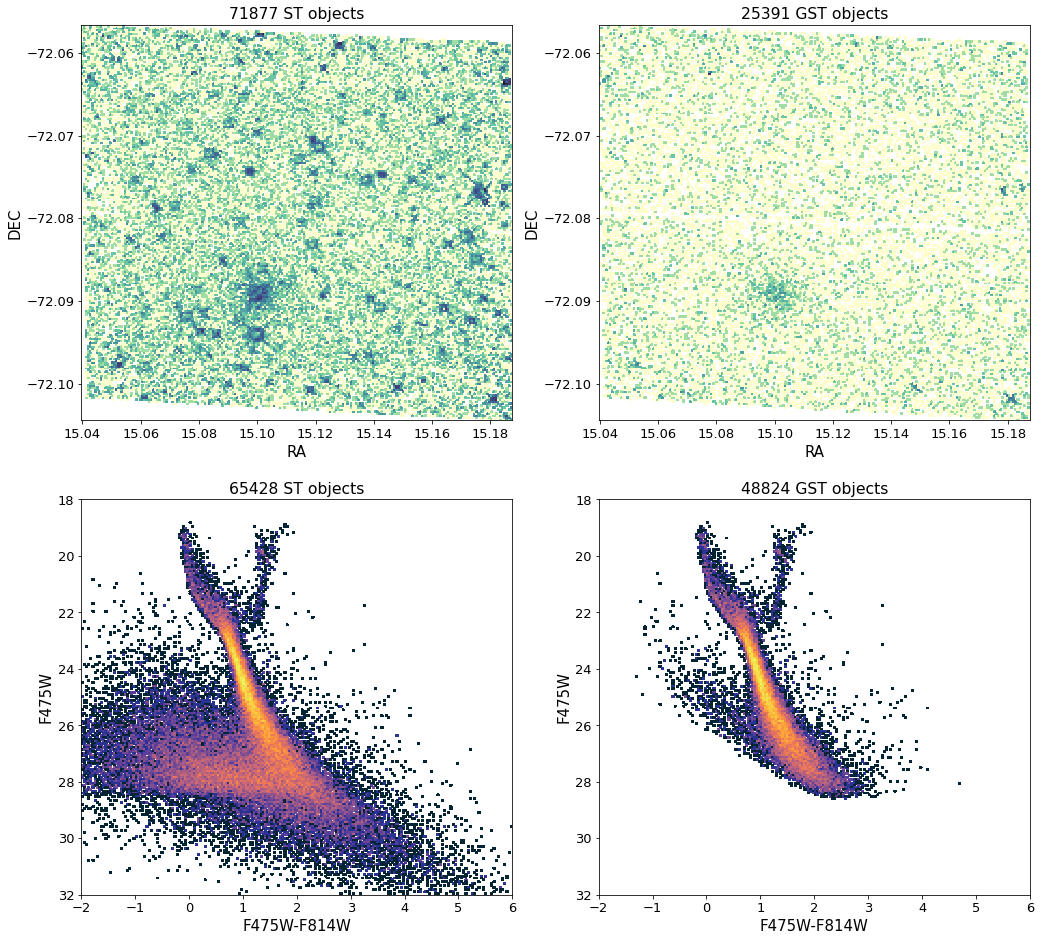

In [38]:
nbins = 200
if plot is False:
    h_map = plt.hist2d(stcat[ra_key], stcat[dec_key], bins=nbins, norm=LogNorm(), cmap=cmocean.cm.deep);
    h = plt.hist2d(stcat[ra_key][default_cut], stcat[dec_key][default_cut],
                   bins=nbins, norm=LogNorm(vmax=h_map[0].max()),
                   range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(), h_map[2].max())), cmap=cmocean.cm.deep);

plt.set_cmap('bone_r')

if plot:
    fig = plt.figure(figsize=(17,16))

    plt.subplot(221)
    h_map = plt.hist2d(stcat[ra_key], stcat[dec_key], bins=nbins, norm=LogNorm(), cmap=cmocean.cm.deep)
    plt.xlabel(ra_key,fontsize=15)
    plt.ylabel(dec_key,fontsize=15)
    plt.title('%d ST objects' % (len(stcat[ra_key])))

    plt.subplot(222)
    h = plt.hist2d(stcat[ra_key][default_cut], stcat[dec_key][default_cut],
                   bins=nbins, norm=LogNorm(vmax=h_map[0].max()),
                   range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(), h_map[2].max())), cmap=cmocean.cm.deep)
    plt.xlabel(ra_key,fontsize=15)
    plt.ylabel(dec_key,fontsize=15)
    plt.title('%d GST objects' % (len(stcat[default_cut])))

    cmd_st_sources = stcat[two_key[0]+'_VEGA'] < 99
    len_cmd_st_sources = len(stcat[cmd_st_sources])
    
    plt.subplot(223)
    h_all = plt.hist2d(stcat[two_key[0]+'_VEGA']-stcat[two_key[1]+'_VEGA'],
                   stcat[two_key[0]+'_VEGA'], bins=200, norm=LogNorm(), 
                   range=((-2,6),(18,32)), cmap=cmocean.cm.thermal)
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(two_key[0]+'-'+two_key[1],fontsize=15)
    plt.ylabel(two_key[0],fontsize=15)
    plt.title('%d ST objects' % (len_cmd_st_sources))

    cmd_gst_sources = gstcat[two_key[0]+'_VEGA'] < 99
    len_cmd_gst_sources = len(gstcat[cmd_gst_sources])
    
    plt.subplot(224)
    h_def = plt.hist2d(stcat[two_key[0]+'_VEGA'][default_cut]-
                       stcat[two_key[1]+'_VEGA'][default_cut],
                       stcat[two_key[0]+'_VEGA'][default_cut], bins=200, 
                       norm=LogNorm(vmax=h_all[0].max()), 
                       range=((-2,6),(18,32)), cmap=cmocean.cm.thermal)
    # plt.ylim(32,18)
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(two_key[0]+'-'+two_key[1],fontsize=15)
    plt.ylabel(two_key[0],fontsize=15)
    plt.title('%d GST objects' % (len_cmd_gst_sources))
    plt.savefig(outDir + 'gst_cuts_spatial_cmd_%s.png' % target)

# Try to remove objects associated with diffraction spikes using kernel filter


In [17]:
# h_map = plt.hist2d(stcat[ra_key], stcat[dec_key], bins=nbins, norm=LogNorm(), cmap=cmocean.cm.deep);
kernel_size = 7
median_map = medfilt(h_map[0], kernel_size=kernel_size)

if plot:
    fig = plt.figure(figsize=(17,14))
    plt.suptitle('Remove spikes: ks=%s, crowd=%s, round=%s, sharp^2=%s' % (kernel_size, crowd_th, round_th, sharp_th))

    plt.subplot(221)
    plt.imshow(h_map[0].T-median_map.T, origin='lower', aspect='auto', cmap=plt.cm.rainbow,
               extent=[h_map[1].min(),h_map[1].max(),h_map[2].min(),h_map[2].max()], vmax=30)
    cb = plt.colorbar()
    cb.set_label('Star Count - Median Star Count')
    plt.title('Star Count (st) - Median Star Count')

    plt.subplot(222)
    h = plt.hist((h_map[0].T-median_map.T).ravel(), bins=150, log=True)
    plt.xlabel('Star Count - Median Star Count')

    plt.subplot(223)
    plt.imshow(median_map.T, origin='lower', aspect='auto', cmap=plt.cm.rainbow,
               extent=[h_map[1].min(),h_map[1].max(),h_map[2].min(),h_map[2].max()])
    cb = plt.colorbar()
    cb.set_label('Median Filtered Star Count')
    plt.title('Median Star Count, ks = %s' % kernel_size)

    plt.subplot(224)
    h = plt.hist(median_map.T.ravel(), bins=150, log=True)
    plt.xlabel('Median Star Count')

    plt.savefig('%sstars-medianstars_%s_ks_%s_crwd_%s_rnd_%s.png' % \
                (outDir, target, kernel_size, crowd_th, round_th), dpi=300)

NameError: name 'h_map' is not defined

## Select a Median star count threshold

In [19]:
import matplotlib.colors as colors
sd_thre = 10

if plot:
    plt.figure(figsize=(16,7))

    plt.subplot(121)
    plt.imshow(h_map[0].T, origin='lower', norm=LogNorm(), aspect='auto',
               extent=[h_map[1].min(),h_map[1].max(),h_map[2].min(),h_map[2].max()],
              cmap=cmocean.cm.deep)
    plt.title('ST catalog')

# Remove sources which, after the median-filtered results are removed, still surpass a threshold.
high_sd = h_map[0] - median_map > sd_thre
len_high_sd = len(np.where(high_sd == True)[0])
print('%s regions with source density above the %d threshold' % (len_high_sd, sd_thre))

if plot:
    plt.subplot(122)
    plt.imshow(h_map[0].T*high_sd.T, origin='lower', cmap=cmocean.cm.deep, aspect='auto',
               extent=[h_map[1].min(),h_map[1].max(),h_map[2].min(),h_map[2].max()]) # norm=colors.LogNorm(vmin=h_map[1].min(), vmax=h_map[1].max()), 
    plt.title('High-density sources, Threshold: %s' % sd_thre)

    plt.savefig(outDir + 'threshold_map_th_' + str(sd_thre) + '_ks_' + str(kernel_size) + '.png')

NameError: name 'plot' is not defined

## Identify sources associated with high src density regions;
## Place a bright sources exception

In [72]:
indices = []
nrow, ncol = h_map[0].shape
print('shape h_map', h_map[0].shape)
# h_map = plt.hist2d(stcat[ra_key], stcat[dec_key], bins=nbins, norm=LogNorm())
for ira in range(nrow):
    for jdec in range(ncol):
        if high_sd[ira,jdec]:
            # original selection: only above threshold
            stars, = np.where((stcat[ra_key] >= h_map[1][ira]) & (stcat[ra_key] < h_map[1][ira+1]) & \
                              (stcat[dec_key] >= h_map[2][jdec]) & (stcat[dec_key] < h_map[2][jdec+1]))
            indices.append(stars.tolist())

indices = np.concatenate(indices).astype('int')

# Code for selection of bright sources
# dim_stars, = np.where((stcat['F336W_VEGA'][stars] > 20))
# indices_diff_spikes.append(dim_stars.tolist())
# remove only sources fainter than 20 mag
# inds_no_bright = np.where(stcat['F475W_VEGA'][indices_diff_spikes] > 20)[0]
# print('Only faint diffraction spikes', min(stcat['F475W_VEGA'][inds_no_bright]))
print('Sources removed as diffraction spikes: %s (%s %%)' % (len(indices), np.around((len(indices) / len(stcat[ra_key]) * 100), decimals=2)))

shape h_map (200, 200)
Sources removed as diffraction spikes: 4715 (6.56 %)


## Combine DS and quality cuts

In [17]:
diff_flag = np.ones(len(stcat), dtype=bool)
diff_flag[indices] = False
final_cut = my_cut & diff_flag

# diff_flag[indices_diff_spikes] = False
# high_sd_true_nonfake = np.where(high_sd_fake is True)[0]
# print(len(high_sd_true))

## Calculate pre- and post- bright-star stats

In [42]:
lt_16_st = (stcat['F336W_VEGA'] < 16.); nlt16st=len(stcat[lt_16_st])
lt_17_st = (stcat['F336W_VEGA'] < 17.); nlt17st=len(stcat[lt_17_st])
lt_18_st = (stcat['F336W_VEGA'] < 18.); nlt18st=len(stcat[lt_18_st])
lt_19_st = (stcat['F336W_VEGA'] < 19.); nlt19st=len(stcat[lt_19_st])
lt_20_st = (stcat['F336W_VEGA'] < 20.); nlt20st=len(stcat[lt_20_st])
all_lt_20_st = nlt16st + nlt17st + nlt18st + nlt19st + nlt20st
print(nlt16st, nlt17st, nlt18st, nlt19st, nlt20st)

lt_16_final = final_cut & (stcat['F336W_VEGA'] < 16.); nlt16fin=len(stcat[lt_16_final])
lt_17_final = final_cut & (stcat['F336W_VEGA'] < 17.); nlt17fin=len(stcat[lt_17_final])
lt_18_final = final_cut & (stcat['F336W_VEGA'] < 18.); nlt18fin=len(stcat[lt_18_final])
lt_19_final = final_cut & (stcat['F336W_VEGA'] < 19.); nlt19fin=len(stcat[lt_19_final])
lt_20_final = final_cut & (stcat['F336W_VEGA'] < 20.); nlt20fin=len(stcat[lt_20_final])
all_lt_20_final = nlt16fin + nlt17fin + nlt18fin + nlt19fin + nlt20fin
print (nlt16fin, nlt17fin, nlt18fin, nlt19fin, nlt20fin)

print('All st stars with F336W_VEGA <= 20 mag: ', all_lt_20_st)
print('All final stars with F336W_VEGA <= 20 mag: ', all_lt_20_final)

1 33 92 206 391
0 0 3 87 216
All st stars with F336W_VEGA <= 20 mag:  723
All final stars with F336W_VEGA <= 20 mag:  306


## Plot final stats

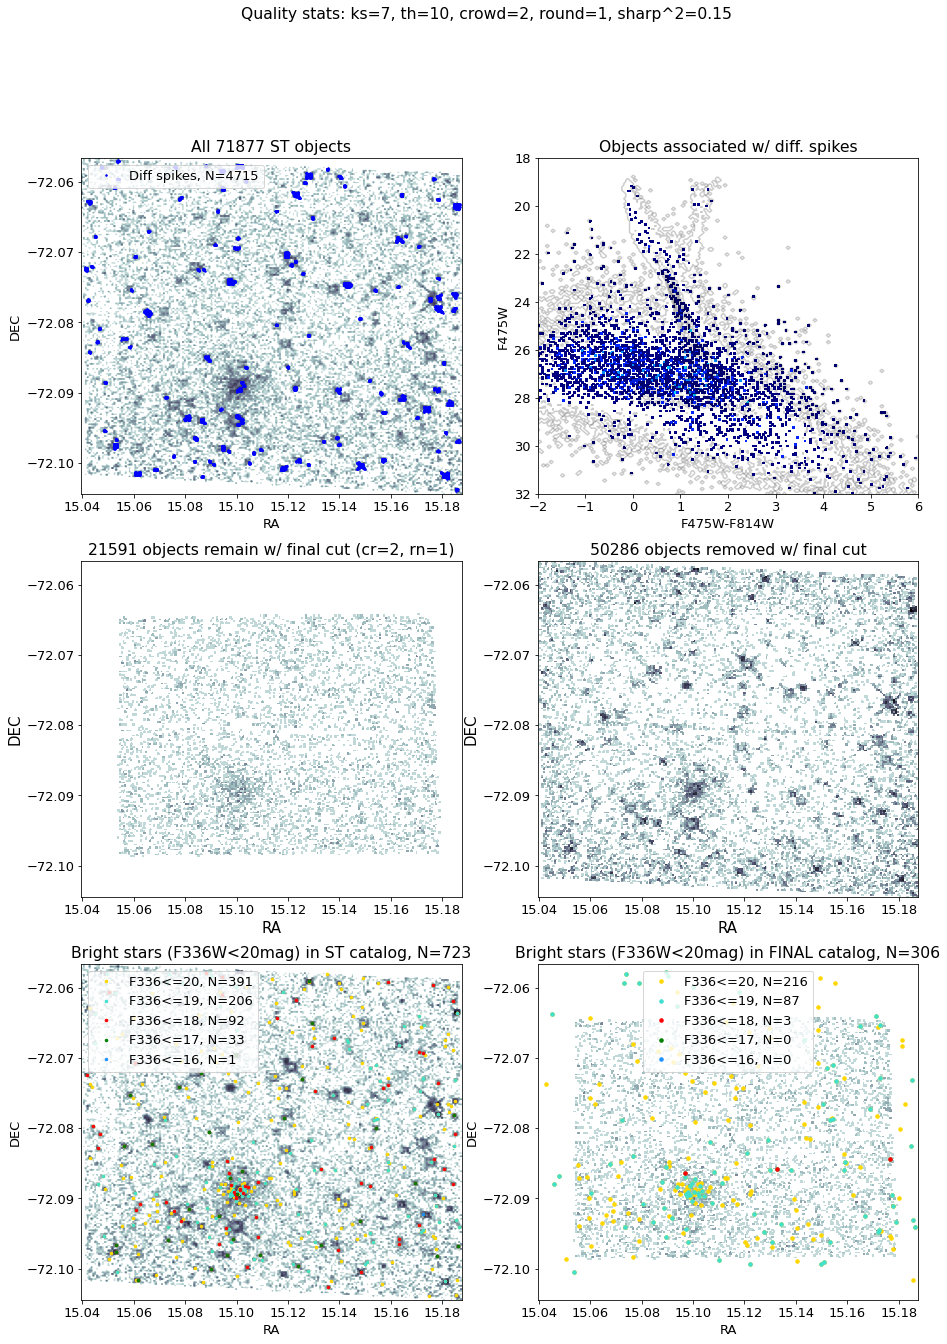

In [43]:
if plot:

    fig = plt.figure(figsize=(15,21))

    plt.suptitle('Quality stats: ks=%s, th=%s, crowd=%s, round=%s, sharp^2=%s' % (kernel_size, sd_thre, crowd_th, round_th, sharp_th))

    plt.subplot(321)
    plt.imshow(h_map[0].T, origin='lower', norm=LogNorm(vmin=1,vmax=h_map[0].max()),
               extent=[h_map[1].min(),h_map[1].max(),h_map[2].min(),h_map[2].max()],
               aspect='auto')
    plt.plot(stcat[ra_key][indices], stcat[dec_key][indices], '.b', ms=3)
    plt.xlabel(ra_key)
    plt.ylabel(dec_key)
    plt.title('All %d ST objects' % (len(stcat[ra_key])))
    plt.legend(['Diff spikes, N=%s' % len(indices)], loc=2)


    plt.subplot(322)
    plt.contour(h_all[0].T, extent=[-2,6,18,32], colors='k', alpha=0.2)
    h = plt.hist2d(stcat[two_key[0]+'_VEGA'][~diff_flag]-stcat[two_key[1]+'_VEGA'][~diff_flag],
                   stcat[two_key[0]+'_VEGA'][~diff_flag], bins=nbins, 
                   norm=LogNorm(vmin=1,vmax=h_all[0].max()), 
                   range=((-2,6),(18,32)), cmap=plt.cm.jet)
    plt.ylim(32,18)
    plt.xlabel(two_key[0]+'-'+two_key[1])
    plt.ylabel(two_key[0])
    plt.title('Objects associated w/ diff. spikes')

    plt.subplot(323)
    # h = plt.hist2d(stcat['RA'][default_cut], stcat['DEC'][default_cut], 
    #                bins=nbins, norm=LogNorm(vmin=1,vmax=h_map[0].max()),
    #                range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(), h_map[2].max())))
    # plt.xlabel('RA',fontsize=15)
    # plt.ylabel('Dec',fontsize=15)
    # plt.title('%d objects with the default GST cut' % (len(stcat[default_cut])))
    h = plt.hist2d(stcat[ra_key][final_cut], stcat[dec_key][final_cut], 
                   bins=nbins, norm=LogNorm(vmin=1,vmax=h_map[0].max()),
                   range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(),h_map[2].max())))
    plt.xlabel(ra_key,fontsize=15)
    plt.ylabel(dec_key,fontsize=15)
    plt.title('%d objects remain w/ final cut (cr=%s, rn=%s)' % (len(stcat[final_cut]), crowd_th, round_th))

    plt.subplot(324)
    # h = plt.hist2d(stcat['RA'][~default_cut], stcat['DEC'][~default_cut], 
    #                bins=nbins, norm=LogNorm(vmin=1,vmax=h_map[0].max()),
    #                range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(),h_map[2].max())))
    # plt.xlabel('RA',fontsize=15)
    # plt.ylabel('Dec',fontsize=15)
    # plt.title('%d objects did not make the default GST cut' % (len(stcat[~default_cut])))
    h = plt.hist2d(stcat[ra_key][~final_cut], stcat[dec_key][~final_cut], 
                   bins=nbins, norm=LogNorm(vmin=1,vmax=h_map[0].max()),
                   range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(),h_map[2].max())))
    plt.xlabel(ra_key,fontsize=15)
    plt.ylabel(dec_key,fontsize=15)
    plt.title('%d objects removed w/ final cut' % (len(stcat[~final_cut])))

    plt.subplot(325)
    # Show original stats on spatial plot
    plt.imshow(h_map[0].T, origin='lower', norm=LogNorm(vmin=1,vmax=h_map[0].max()),
               extent=[h_map[1].min(),h_map[1].max(),h_map[2].min(),h_map[2].max()],
               aspect='auto')
    plt.plot(stcat[ra_key][lt_20_st], stcat[dec_key][lt_20_st], '.', c='gold', ms=5, label='F336<=20, N=%s' % nlt20st)
    plt.plot(stcat[ra_key][lt_19_st], stcat[dec_key][lt_19_st], '.', c='turquoise', ms=5, label='F336<=19, N=%s' % nlt19st)
    plt.plot(stcat[ra_key][lt_18_st], stcat[dec_key][lt_18_st], '.', c='red', ms=5, label='F336<=18, N=%s' % nlt18st)
    plt.plot(stcat[ra_key][lt_17_st], stcat[dec_key][lt_17_st], '.', c='green', ms=5, label='F336<=17, N=%s' % nlt17st)
    plt.plot(stcat[ra_key][lt_16_st], stcat[dec_key][lt_16_st], '.', c='dodgerblue', ms=5, label='F336<=16, N=%s' % nlt16st)
    plt.xlabel(ra_key)
    plt.ylabel(dec_key)
    plt.title('Bright stars (F336W<20mag) in ST catalog, N=%s' % all_lt_20_st)
    plt.legend()

    plt.subplot(326)
    # Show resulting stats on spatial plot
    h = plt.hist2d(stcat[ra_key][final_cut], stcat[dec_key][final_cut], 
                   bins=nbins, norm=LogNorm(vmin=1,vmax=h_map[0].max()),
                   range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(),h_map[2].max())))
    plt.plot(stcat[ra_key][lt_20_final], stcat[dec_key][lt_20_final], '.', c='gold', ms=7, label='F336<=20, N=%s' % nlt20fin)
    plt.plot(stcat[ra_key][lt_19_final], stcat[dec_key][lt_19_final], '.', c='turquoise', ms=7, label='F336<=19, N=%s' % nlt19fin)
    plt.plot(stcat[ra_key][lt_18_final], stcat[dec_key][lt_18_final], '.', c='red', ms=7, label='F336<=18, N=%s' % nlt18fin)
    plt.plot(stcat[ra_key][lt_17_final], stcat[dec_key][lt_17_final], '.', c='green', ms=7, label='F336<=17, N=%s' % nlt17fin)
    plt.plot(stcat[ra_key][lt_16_final], stcat[dec_key][lt_16_final], '.', c='dodgerblue', ms=7, label='F336<=16, N=%s' % nlt16fin)
    plt.xlabel(ra_key)
    plt.ylabel(dec_key)
    plt.title('Bright stars (F336W<20mag) in FINAL catalog, N=%s' % all_lt_20_final)
    plt.legend()


    plt.savefig(outDir+'clean_catalog_%s_ks_%s_th_%s_crwd_%s_rnd_%s_bright_%s.png' % \
                (target, kernel_size, sd_thre, crowd_th, round_th, all_lt_20_final), dpi=300)

## Add 'CUT_FLAG' columns; turn F336W_IN NaNs into 99s

In [44]:
# open catalog as a table to add columns
# t = Table.read(inDir+'15891_%s.st.fake.fits' % target)
# t_vgst = Table.read(inDir+'15891_%s.vgst.fake.fits' % target)

# t = Table.read(stfile)

# Designate F336W_IN = NaN with 99s (otherwise error)
if fake_cat:
    f336nan = np.isnan(stcat['F336W_IN'])
    print('N (F336W_IN = NaN)', len(np.where(f336nan == True)[0])) # N=9574
    t["F336W_IN"][f336nan] = 99

# add RA/DEC columns; not needed.
# t.add_column(np.zeros(len(t[ra_key])), name="RA", index=-1)
# t.add_column(np.zeros(len(t[dec_key])), name="DEC", index=-1)
# t["RA"] = t[ra_key]
# t["DEC"] = t[dec_key]

# keep bad sources in catalog and flag them with a new column, CUT_FLAG = 1
add_cutflag=True
if add_cutflag:
    t.add_column(np.zeros(len(t), dtype=int), name="CUT_FLAG", index=-1)
    t["CUT_FLAG"][~final_cut] = 1
    t["CUT_FLAG"][final_cut] = 0

## Write new catalog

In [45]:
# hdu = fits.BinTableHDU(data=stcat[final_cut])
# hdu.writeto(inDir+'15275_%s.vgst.fits' % (target), overwrite=True)

hdu = fits.BinTableHDU(data=t)
outcat = inDir + '15891_%s_%s_%s_%s_%s_with_cutflag.est.fits' % (target, kernel_size, sd_thre, crowd_th, round_th)
hdu.writeto(outcat, overwrite=True)

### Make a source density map

In [26]:
flag_filter = ["F475W"]
ref_filter = ["F475W"]
pixsize = 5
print('Confirm resulting catalog:', outcat)

peak_mags = plot_mag_hist.plot_mag_hist(outcat, stars_per_bin=70, max_bins=75)

# Try to make sure the pixel size matches the kernel size
sourceden_args = types.SimpleNamespace(
                subcommand="sourceden",
                catfile=outcat,
                erode_boundary=0.1,
                pixsize=pixsize,
                npix=None,
                mag_name=ref_filter[0] + "_VEGA",
                mag_cut=[16, peak_mags[ref_filter[0]] - 0.5],
                flag_name=flag_filter[0] + "_FLAG",
            )
create_background_density_map.main_make_map(sourceden_args)

Confirm resulting catalog: /Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_7_10_2_1_with_cutflag.est.fits
# of x & y pixels =  33 35
working on converting ra, dec to pix x,y


### Group tiles by density bin (optional)

In [27]:
map_file = outcat.replace(".fits", "_sourceden_map.hd5")
sd_binmode = "custom"
#sd_custom = [0.5, 1, 2, 2.5, 3, 3.5, 4, 5, 10]
#sd_custom = [0.2,0.5,0.8,1.1,1.4,1.7,2.0,2.3,2.6]

bdm = BinnedDensityMap.create(
        map_file,
        bin_mode="linear",
        N_bins=None,
        bin_width=None,
        custom_bins=None,
    )


## Reading in the new catalog, to ensure correctness

In [46]:
cat_t = Table.read(outcat)
scylla_t = cat_t
print('Number of sources in trimmed catalog (%s): %s' % (outcat, len(scylla_t)))

Number of sources in trimmed catalog (/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_7_10_2_1_with_cutflag.est.fits): 71877


In [47]:
bin_foreach_source = np.zeros(len(scylla_t), dtype=int)

# Find the density bin into which each ra, dec source fits
for i in range(len(cat_t)):
    bin_foreach_source[i] = bdm.bin_for_position(
            scylla_t[ra_key][i], scylla_t[dec_key][i]
        )
print('len and max bin_foreach_source', len(bin_foreach_source), max(bin_foreach_source[:]))
print('shape bin_foreach_source', np.shape(bin_foreach_source))
    
# Find the RA/DEC indices for each bin
binnrs = np.unique(bin_foreach_source)
bin_idxs = []
for b in binnrs:
    sources_for_bin = bin_foreach_source == b
    bin_idxs.append(sources_for_bin)

n_srcs_in_bin = []
for k in range(len(binnrs)):
    cat = cat_t[bin_idxs[k]]
#     print(binnrs[k], np.shape(cat['RA']))
    n_srcs_in_bin.append(np.shape(cat['RA'])[0])
# print(n_srcs_in_bin, sum(n_srcs_in_bin))
print('max n_srcs_in_bin', max(n_srcs_in_bin))

len and max bin_foreach_source 71877 1152
shape bin_foreach_source (71877,)
max n_srcs_in_bin 395


## Plot the source density map and the density bin of each ra/dec

21591


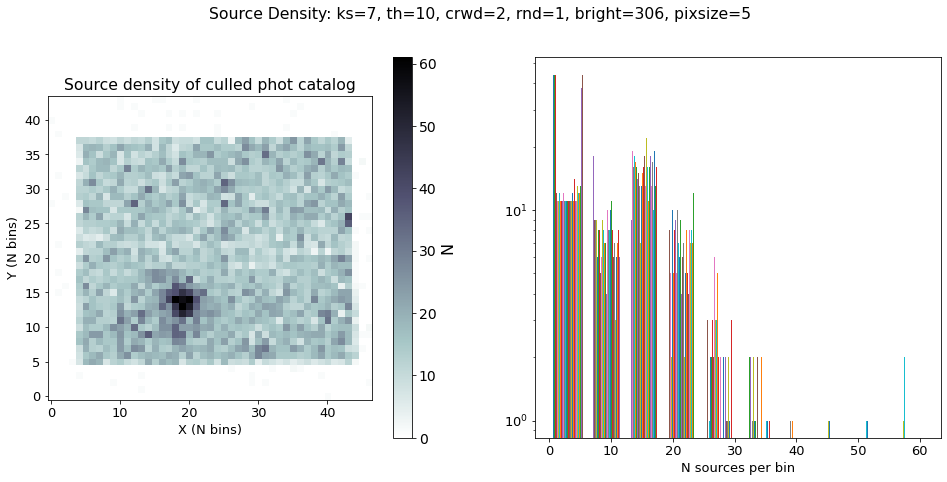

In [48]:
plot_ast_cat = True

# if plotting the photometry st catalog stats
if plot_ast_cat is False:
    outcat_src_den_img = outcat.replace(".fits", "_source_den_image.fits")
    src_den_img = fits.open(outcat_src_den_img)[0].data
    # print('max src_den_img', max(src_den_img))

    plt.figure(figsize=(16,16))
    plt.suptitle('Source Density: ks=%s, th=%s, crwd=%s, rnd=%s, bright=%s, pixsize=%s' % \
                (kernel_size, sd_thre, crowd_th, round_th, all_lt_20_final, pixsize))

    # Plot the source density image
    plt.subplot(221)
    im = plt.imshow(src_den_img, origin="lower")
    plt.colorbar(im, label='N / 1 arcsec$^2$ (total N per %sx%s=%s*colorbar value)')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("BEAST: Source density per %s arcsec$^2$" % pixsize)

    # Histogram of number of sources in each source density bin
    plt.subplot(222)
    plt.bar(binnrs, n_srcs_in_bin)
    plt.title('BEAST: N sources in each src density bin')

    nbins = [47,44] # [47,44] for 5" pixsize
    # 2D histogram for the stcat
    # h_st, xedges_st, yedges_st = np.histogram2d(stcat['RA'], stcat['DEC'], bins=nbins)
    # plt.subplot(223)
    # h2d_st = plt.imshow(h_st.T, origin='lower')
    # plt.colorbar(h2d_st)
    # plt.title('st catalog')

    # 2D hist for the new vgst catalog
    cuts = (scylla_t['CUT_FLAG'] == 0)
    
    h = plt.hist2d(scylla_t[ra_key][cuts], scylla_t[dec_key][cuts], 
               bins=nbins, norm=LogNorm())

#     h, xedges, yedges = np.histogram2d(scylla_t['RA'], scylla_t['DEC'], bins=nbins)
    plt.subplot(223)
    h2d = plt.imshow(h.T, origin='lower')
    plt.colorbar(h2d)
    plt.title('np.hist2d: Src den 47 x 44 bins')


    # histogram of number of sources per bin
    plt.subplot(224)
    plt.hist((h[1].T), bins=10, log=True)
    plt.xlabel('Histogram: N sources per bin in y')


if plot_ast_cat:
    
    cuts = (scylla_t['CUT_FLAG'] == 0)
    print(len(np.where(cuts==True)[0]))
    
    fig = plt.figure(figsize=(16,7))

    plt.suptitle('Source Density: ks=%s, th=%s, crwd=%s, rnd=%s, bright=%s, pixsize=%s' % \
                (kernel_size, sd_thre, crowd_th, round_th, all_lt_20_final, pixsize))

    nbins = [47,44] # [47,44] for 5" pixsize
    # 2D hist for the new vgst catalog
    plt.subplot(121)
#     h_plt = plt.hist2d(scylla_t[ra_key], scylla_t[dec_key], bins=nbins, norm=LogNorm());
#     fig.colorbar(h[3])#, ax=ax)
    h, xedges, yedges = np.histogram2d(scylla_t[ra_key][cuts], scylla_t[dec_key][cuts], bins=nbins) #, normed=LogNorm())

    cb = plt.imshow(h.T, origin='lower')#,norm=LogNorm())
    cbar = plt.colorbar(cb)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label='N', size=16)
    plt.xlabel('X (N bins)')
    plt.ylabel('Y (N bins)')
    
    plt.title('Source density of culled phot catalog')

    # histogram of number of sources per bin
    plt.subplot(122)
#     plt.hist(h[0], bins=10, log=True)
    plt.hist(h.T, bins=10, log=True)
    plt.xlabel('N sources per bin')

plt.savefig(outDir+'source_density_bins_%s_ks_%s_th_%s_crwd_%s_rnd_%s_bright_%s.png' % \
            (target, kernel_size, sd_thre, crowd_th, round_th, all_lt_20_final), dpi=300)



## Range of source densities for culled photometry catalog

In [49]:
src_den_range = h.max() - h.min()
print('h min; h max', h.min(), h.max())
print('The source density range:', src_den_range)

h min; h max 0.0 61.0
The source density range: 61.0


# Part II. Apply photometric quality cuts to st.fake

In [22]:
print('Phot thresholds (crowd, sharp^2, round):', crowd_th, sharp_th, round_th)
print('Density params (kernel size, density threshold):', kernel_size, sd_thre)

st_fake_t = Table.read(scylla_st_asts)
print('Total # of sources in AST catalog:', len(st_fake_t))

filters_fake = [x.split('_')[0] for x in st_fake_t.colnames if "VEGA" in x]
print(filters_fake)

# Cut on DOLPHOT flag. Keep only sources with flag=0 or 2
flag_cut_fake = ((st_fake_t[two_key[0]+'_FLAG'] == 0) | (st_fake_t[two_key[0]+'_FLAG'] == 2)) & \
           ((st_fake_t[two_key[1]+'_FLAG'] == 0) | (st_fake_t[two_key[1]+'_FLAG'] == 2))
print('FLAG cut/remaining:', len(st_fake_t[~flag_cut_fake]), '/', len(st_fake_t[flag_cut_fake]))

# Cut on RATE. If a source has rate=0 in any band, then it needs to be cut.
# Yumi: Keep only sources with rate != 0.0 in ALL bands
rate_cut_fake = np.all([st_fake_t[x+'_RATE']!=0 for x in filters_fake], axis=0)

print('RATE cut/remaining: %s / %s (rem. %s %%)' % (len(st_fake_t[~rate_cut_fake]), len(st_fake_t[rate_cut_fake]), np.around(len(st_fake_t[rate_cut_fake]) / len(st_fake_t) * 100, decimals=1)))

# Cut on CROWD. Keep only sources with CROWD < crowd_threshold (GST default=2.25)
crowd_cut_fake = (st_fake_t[two_key[0]+'_CROWD'] < crowd_th) & \
            (st_fake_t[two_key[1]+'_CROWD'] < crowd_th)
print('CROWD cut/remaining:', len(st_fake_t[~crowd_cut_fake]), '/', len(st_fake_t[crowd_cut_fake]))

# Cut on SHARP. Keep only sources with sharp**2 < sharp_threshold (GST default=0.2)
sharp_cut_fake = (st_fake_t[two_key[0]+'_SHARP']**2 < sharp_th) & \
            (st_fake_t[two_key[1]+'_SHARP']**2 < sharp_th)
print('SHARP cut/remaining:', len(st_fake_t[~sharp_cut_fake]), '/', len(st_fake_t[sharp_cut_fake]))

# Cut on ROUND. Keep only sources with round < round_threshold (no ROUND cut in the default cut)
round_cut_fake = (st_fake_t[two_key[0]+'_ROUND'] < round_th) & \
            (st_fake_t[two_key[1]+'_ROUND'] < round_th)
print('ROUND remaining:', len(st_fake_t[~round_cut_fake]), len(st_fake_t[round_cut_fake]))

# Cut on bright sources. Keep sources with F475W_VEGA <= bright_threshold
bright_cut_fake = (st_fake_t[two_key[0]+'_VEGA'] <= bright_th)
print('Bright stars (f475w_vega <= %s): %s' % (bright_th, len(st_fake_t[bright_cut_fake])))


qual_cut_fake = crowd_cut_fake & sharp_cut_fake & round_cut_fake
my_cut_fake = crowd_cut_fake & sharp_cut_fake & round_cut_fake & flag_cut_fake & rate_cut_fake | bright_cut_fake
len_my_cut_fake_removed = len(st_fake_t[~my_cut_fake])
print('Total sources cut/remaining after all quality cuts (phot, flag, and rate):', len(st_fake_t[~my_cut_fake]), '/', len(st_fake_t[my_cut_fake]), '(%s%% / %s%%)' % (np.around(len(st_fake_t[~my_cut_fake]) / len(st_fake_t) * 100, decimals=2), np.around(len(st_fake_t[my_cut_fake]) / len(st_fake_t) * 100, decimals=2)))

my_cut_no_bright_fake = crowd_cut_fake & sharp_cut_fake & round_cut_fake & flag_cut_fake & rate_cut_fake


Phot thresholds (crowd, sharp^2, round): 0.3 0.15 0.6
Density params (kernel size, density threshold): 7 10
Total # of sources in AST catalog: 31353
['F110W', 'F160W', 'F275W', 'F336W', 'F475W', 'F814W']
FLAG cut/remaining: 0 / 31353
RATE cut/remaining: 22427 / 8926 (rem. 28.5 %)
CROWD cut/remaining: 2304 / 29049
SHARP cut/remaining: 2090 / 29263
ROUND remaining: 1758 29595
Bright stars (f475w_vega <= 20): 1164
Total sources cut/remaining after all quality cuts (phot, flag, and rate): 25471 / 5882 (81.24% / 18.76%)


## Apply est median filter cuts to st.fake - Part A: Identify diffraction spikes

shape h_map_f (200, 200)


NameError: name 'high_sd' is not defined

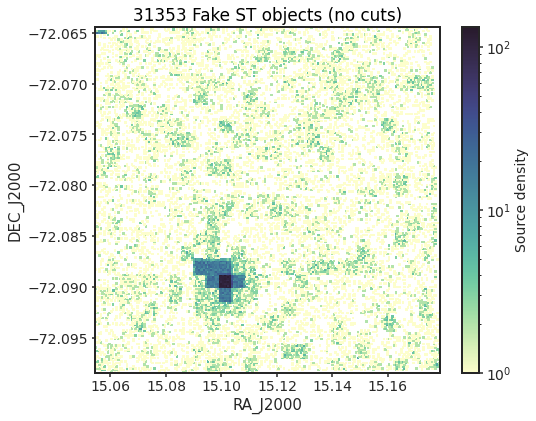

In [26]:
if 'RA' in st_fake_t.colnames:
    ra_key_f = "RA"
    dec_key_f = "DEC"
else:
    ra_key_f = "RA_J2000"
    dec_key_f = "DEC_J2000"

# Plot a histogram of the st catalog; also plot the obs cat for comparison
fig = plt.figure(figsize=(17,14))

nbins_f=200
plt.subplot(221)
h_map_f = plt.hist2d(st_fake_t[ra_key_f], st_fake_t[dec_key_f], bins=nbins_f, norm=LogNorm(), cmap=cmocean.cm.deep)
cb = plt.colorbar()
cb.set_label('Source density')
plt.xlabel(ra_key_f,fontsize=15)
plt.ylabel(dec_key_f,fontsize=15)
plt.title('%d Fake ST objects (no cuts)' % (len(st_fake_t)))

# Select high density sources in obs cat, but within st.fake RA/DEC range
# designate the RA/DEC AST catalog range
ra_f_range = [np.min(st_fake_t[ra_key_f]), np.max(st_fake_t[ra_key_f])]
dec_f_range = [np.min(st_fake_t[dec_key_f]), np.max(st_fake_t[dec_key_f])]
# print('RA range', ra_f_range)
# print('DEC range', dec_f_range)

indices_f = []
nrow_f, ncol_f = h_map_f[0].shape
print('shape h_map_f', h_map_f[0].shape)
for ira_f in range(nrow_f):
    for jdec_f in range(ncol_f):
        if high_sd[ira_f,jdec_f]:
            stars, = np.where((stcat[ra_key] >= h_map[1][ira_f]) & (stcat[ra_key] < h_map[1][ira_f+1]) & \
                              (stcat[dec_key] >= h_map[2][jdec_f]) & (stcat[dec_key] < h_map[2][jdec_f+1]))
            indices_f.append(stars.tolist())
indices_f = np.concatenate(indices_f).astype('int')
print('len indices_f', len(indices_f))        

diff_flag_f = np.ones(len(st_fake_t), dtype=bool)
diff_flag_f[indices_f] = False
#final_cut_f = my_cut & diff_flag

plt.subplot(222)
plt.hist2d(stcat[ra_key], stcat[dec_key], bins=nbins, norm=LogNorm(), cmap=cmocean.cm.deep)
cb = plt.colorbar()
plt.xlabel(ra_key,fontsize=15)
plt.ylabel(dec_key,fontsize=15)
plt.title('%d ST objects (no cuts)' % (len(stcat[ra_key])))

plt.subplot(223)
h_cut_fake = plt.hist2d(st_fake_t[ra_key_f][diff_flag_f], st_fake_t[dec_key_f][diff_flag_f],
               bins=nbins_f, norm=LogNorm(vmax=h_map_f[0].max()), cmap=cmocean.cm.deep,
               range=((h_map_f[1].min(),h_map_f[1].max()),(h_map_f[2].min(), h_map_f[2].max())))

plt.subplot(224)
plt.hist2d(stcat[ra_key][diff_flag], stcat[dec_key][diff_flag],
               bins=nbins, norm=LogNorm(vmax=h_map[0].max()), cmap=cmocean.cm.deep,
               range=((h_map[1].min(),h_map[1].max()),(h_map[2].min(), h_map[2].max())))

In [28]:
# Use same kernel size as the one applied on the photometry catalog
h_map_fake = h_map_f
median_map_fake = medfilt(h_map_fake[0], kernel_size=kernel_size)

if plot:
    fig = plt.figure(figsize=(17,14))
    plt.suptitle('Remove spikes: ks=%s, crowd=%s, round=%s, sharp^2=%s' % (kernel_size, crowd_th, round_th, sharp_th))

    plt.subplot(221)
    plt.imshow(h_map_fake[0].T - median_map_fake.T, origin='lower', aspect='auto', cmap=plt.cm.rainbow,
               extent=[h_map_fake[1].min(),h_map_fake[1].max(),h_map_fake[2].min(),h_map_fake[2].max()], vmax=30)
    cb = plt.colorbar()
    cb.set_label('Star Count - Median Star Count')
    plt.title('Star Count (st) - Median Star Count')

    plt.subplot(222)
    h_fake = plt.hist((h_map_fake[0].T - median_map_fake.T).ravel(), bins=150, log=True)
    plt.xlabel('Star Count - Median Star Count')
    plt.xlim(-700, 4000)

    plt.subplot(223)
    plt.imshow(median_map_fake.T, origin='lower', aspect='auto', cmap=plt.cm.rainbow,
               extent=[h_map_fake[1].min(),h_map_fake[1].max(),h_map_fake[2].min(),h_map_fake[2].max()])
    cb = plt.colorbar()
    cb.set_label('Median Filtered Star Count')
    plt.title('Median Star Count, ks = %s' % kernel_size)

    plt.subplot(224)
    h_fake = plt.hist(median_map_fake.T.ravel(), bins=150, log=True)
    plt.xlabel('Median Star Count')

    plt.savefig('%sstars-medianstars_%s_ks_%s_crwd_%s_rnd_%s_fake.png' % \
                (outDir, target, kernel_size, crowd_th, round_th), dpi=300)

## Apply est median filter cuts to st.fake - Part B: Source density threshold

In [29]:
plot=False
sd_thre_fake = 50

if plot:
    plt.figure(figsize=(16,7))

    plt.subplot(121)
    plt.imshow(h_map_fake[0].T, origin='lower', norm=LogNorm(), aspect='auto',
               extent=[h_map_fake[1].min(),h_map_fake[1].max(),h_map_fake[2].min(),h_map_fake[2].max()],
              cmap=cmocean.cm.deep)
    plt.title('ST.fake catalog')

# Remove sources which, after the median-filtered results are removed, still surpass a threshold.
high_sd_fake = h_map_fake[0] - median_map_fake > sd_thre_fake
len_high_sd_fake = len(np.where(high_sd_fake == True)[0])
print('%s regions with source density above the %d threshold' % (len_high_sd_fake, sd_thre_fake))

if plot:
    plt.subplot(122)
    plt.imshow(h_map_fake[0].T * high_sd_fake.T, origin='lower', norm=colors.LogNorm(vmin=h_map_fake[1].min(), vmax=h_map[1].max()), cmap=cmocean.cm.deep, aspect='auto',
               extent=[h_map_fake[1].min(),h_map_fake[1].max(),h_map_fake[2].min(),h_map_fake[2].max()])
    plt.title('High-density sources threshold: %s' % sd_thre_fake)

    plt.savefig(outDir + target + 'threshold_map_th_' + str(sd_thre_fake) + '_ks_' + str(kernel_size) + '.png')

20 regions with source density above the 50 threshold


### Select diffraction spikes sources based on high density threshold

In [30]:
inds_ds_fake = []
nrow_f, ncol_f = h_map_fake[0].shape
#high_sd_fake = h_map_fake[0] - median_map_fake > sd_thre_fake
print(high_sd_fake.shape)

for ira in range(nrow_f):
    for jdec in range(ncol_f):
        # If this ra/dec value of the high_sd_fake 2d hist is True (above the set threshold), then proceed
        if high_sd_fake[ira,jdec]:
            # original selection: only above threshold
            stars_fake, = np.where((st_fake_t[ra_key_f] >= h_map_fake[1][ira]) & (st_fake_t[ra_key_f] < h_map_fake[1][ira+1]) & \
                              (st_fake_t[dec_key_f] >= h_map_fake[2][jdec]) & (st_fake_t[dec_key_f] < h_map_fake[2][jdec+1]))
            inds_ds_fake.append(stars_fake.tolist())
inds_ds_fake = np.concatenate(inds_ds_fake).astype('int')

diff_flag_fake = np.ones(len(st_fake_t), dtype=bool)
diff_flag_fake[inds_ds_fake] = False

(200, 200)


### Select final cut

In [31]:
#Trying out different cuts to see result in completeness
# original:
# final_cut_fake = my_cut_fake & diff_flag_fake

# if using a diffraction spikes density cut, uncomment this line:
chosen_cut_fake = qual_cut_fake & diff_flag_fake

# Otherwise uncomment this line:
#chosen_cut_fake = qual_cut_fake & flag_cut_fake
final_cut_fake = chosen_cut_fake

len_diff_flag_fake = len(st_fake_t[diff_flag_fake])
len_final_cut_fake = len(st_fake_t[final_cut_fake])

print('Total # of sources in catalog:', len(st_fake_t))
print('Phot thresholds (crowd, sharp^2, round):', crowd_th, sharp_th, round_th)
print('Median filter params (if used): kernel size=%s; density th=%s' % (kernel_size, sd_thre_fake))

print('N sources selected for removal as diffraction spikes only from st.fake: %s (%s %%)' % (len_diff_flag_fake, np.around((len_diff_flag_fake / len(st_fake_t)), decimals=2) * 100))
print('N sources selected for removal by phot. quality cuts (crowd, sharp, crowd and flag only) from st.fake:', len(st_fake_t[~qual_cut_fake]) + len(st_fake_t[~flag_cut_fake]))
print('N sources selected for removal by quality cuts (incl. flux and flag) from st.fake:', len_my_cut_fake_removed, '(%s %%)' % (np.around(len_my_cut_fake_removed / len(st_fake_t), decimals=3) * 100))
print ('N sources selected for removal by zero_flux_flag only: %s (%s %%)' % (len(st_fake_t[~rate_cut_fake]), np.around(len(st_fake_t[~rate_cut_fake]) / len(st_fake_t) * 100, decimals=2)))
print('N total sources actually removed from st fake: %s (%s %%)' % (len(st_fake_t[~final_cut_fake]), np.around(len(st_fake_t[~final_cut_fake]) / len(st_fake_t), decimals=2) * 100))
print('N total sources actually remaining in st.fake:', len_final_cut_fake, '(%s %%)' % (np.around(len_final_cut_fake / len(st_fake_t), decimals=2) * 100))

Total # of sources in catalog: 31353
Phot thresholds (crowd, sharp^2, round): 0.3 0.15 0.6
Median filter params (if used): kernel size=7; density th=50
N sources selected for removal as diffraction spikes onlyfrom st.fake: 29217 (93.0 %)
N sources selected for removal by phot. quality cuts (crowd, sharp, crowd and flag only) from st.fake: 3632
N sources selected for removal by quality cuts (incl. flux and flag) from st.fake: 25471 (81.2 %)
N sources selected for removal by zero_flux_flag only: 22427 (71.53 %)
N total sources actually removed from st fake: 5481 (17.0 %)
N total sources actually remaining in st.fake: 25872 (83.0 %)


## Record catalog with cuts ('est.fake' or else); correct NaNs

In [44]:
test_completeness = True
write_catalogs = False

f336nan_fake = np.isnan(st_fake_t['F336W_IN'])
print('N (F336W_IN = NaN):', len(st_fake_t[f336nan_fake])) # N=9574
st_fake_t["F336W_IN"][f336nan_fake] = 99

# Check if st.fake has CUT_FLAG colum. If not, create it.
if write_catalogs:
    if "CUT_FLAG" not in st_fake_t.colnames:
        print("Adding a CUT_FLAG")
        st_fake_t.add_column(np.zeros(len(st_fake_t), dtype=int), name="CUT_FLAG", index=-1)

    # making sure cut_flag=0 if multiple tests have recorded 0s and 1s in catalog
    st_fake_t["CUT_FLAG"] = 0

# Only for testing how cutting catalog based on 3 different criteria affects completeness
if test_completeness:
    # Catalog with ONLY flag cuts
    if write_catalogs:
        st_fake_t["CUT_FLAG"][flag_cut_fake] = 0
        st_fake_t["CUT_FLAG"][~flag_cut_fake] = 1
        outcat_fake_cut_flag_only = inDir + '15891_%s_cut_flag_only_Ncut_%s.fake.fits' % (target, len(st_fake_t[~flag_cut_fake]))
        st_fake_t.write(outcat_fake_cut_flag_only, overwrite=True)
    len_f_cut = len(st_fake_t[~flag_cut_fake])
    len_f_stay = len(st_fake_t[flag_cut_fake])

    # Catalog with ONLY photometric quality cuts (no median filter)
    phot_cut = qual_cut_fake & flag_cut_fake
    if write_catalogs:
        st_fake_t["CUT_FLAG"][phot_cut] = 0
        st_fake_t["CUT_FLAG"][~phot_cut] = 1
        outcat_fake_cut_phot_only = inDir + '15891_%s_cut_phot_only_Ncut_%s.fake.fits' % (target, len(st_fake_t[~phot_cut]))
        st_fake_t.write(outcat_fake_cut_phot_only, overwrite=True)
    len_p_cut = len(st_fake_t[~phot_cut])
    len_p_stay = len(st_fake_t[phot_cut])
    
    # Catalog with ONLY photometric quality cuts (selected with median filter)
    phot_cut_medfilt = qual_cut_fake & flag_cut_fake & diff_flag_fake
    if write_catalogs:
        st_fake_t["CUT_FLAG"][phot_cut_medfilt] = 0
        st_fake_t["CUT_FLAG"][~phot_cut_medfilt] = 1
        outcat_fake_cut_phot_w_medfilt_only = inDir + '15891_%s_cut_phot_w_medfilt_only_Ncut_%s.fake.fits' % (target, len(st_fake_t[~phot_cut]))
        st_fake_t.write(outcat_fake_cut_phot_w_medfilt_only, overwrite=True)
    len_pmf_cut = len(st_fake_t[~phot_cut_medfilt])
    len_pmf_stay = len(st_fake_t[phot_cut_medfilt])
    print('N cut phot qual + med filt:', len_pmf_cut)
    print('N remaining phot qual + med filt:', len_pmf_stay)
    
    # Catalog with ONLY zero-flux cuts
    if write_catalogs:
        st_fake_t["CUT_FLAG"] = 0
        st_fake_t["CUT_FLAG"][rate_cut_fake] = 0
        st_fake_t["CUT_FLAG"][~rate_cut_fake] = 1
        outcat_fake_cut_rate_only = inDir + '15891_%s_cut_rate_zero_only_Ncut_%s.fake.fits' % (target, len(st_fake_t[~rate_cut_fake]))
        st_fake_t.write(outcat_fake_cut_rate_only, overwrite=True)
    len_r_cut = len(st_fake_t[~rate_cut_fake])
    len_r_stay = len(st_fake_t[rate_cut_fake])
    
    # Catalog with BOTH photometric quality and zero-flux cuts
    phot_and_rate_cut = phot_cut_medfilt & rate_cut_fake
    if write_catalogs:
        st_fake_t["CUT_FLAG"] = 0
        st_fake_t["CUT_FLAG"][phot_and_rate_cut] = 0
        st_fake_t["CUT_FLAG"][~phot_and_rate_cut] = 1
        outcat_fake_cut_phot_and_rate = inDir + '15891_%s_cut_both_photqual_and_ratezero_Ncut_%s.fake.fits' % (target, len(st_fake_t[~phot_and_rate_cut]))
        st_fake_t.write(outcat_fake_cut_phot_and_rate, overwrite=True)
    len_pr_cut = len(st_fake_t[~phot_and_rate_cut])
    len_pr_stay = len(st_fake_t[phot_and_rate_cut])
    
else:
    if write_catalogs:
        # designate removed sources with cut_flag of 1
        st_fake_t["CUT_FLAG"][final_cut_fake] = 0
        st_fake_t["CUT_FLAG"][~final_cut_fake] = 1
        outcat_fake = inDir + '15891_%s_Ncut_%s.est.fake.fits' % (target, len(st_fake_t[~final_cut_fake]))
        st_fake_t.write(outcat_fake, overwrite=True)
    
#use Table.write to record file

# hdu_stfake = fits.BinTableHDU(data=st_fake_t)
# hdu_stfake.writeto(outcat_fake, overwrite=True)

N (F336W_IN = NaN): 0
N cut phot qual + med filt: 5481
N remaining phot qual + med filt: 25872


## Plot st.fake cuts

st.fake cleaned catalogs saved as /Users/pyanchulova/Documents/scylla/clean_st_3_catalog_SMC-3370ne-13459_ks_7_th_50_crwd_2_rnd_1.png


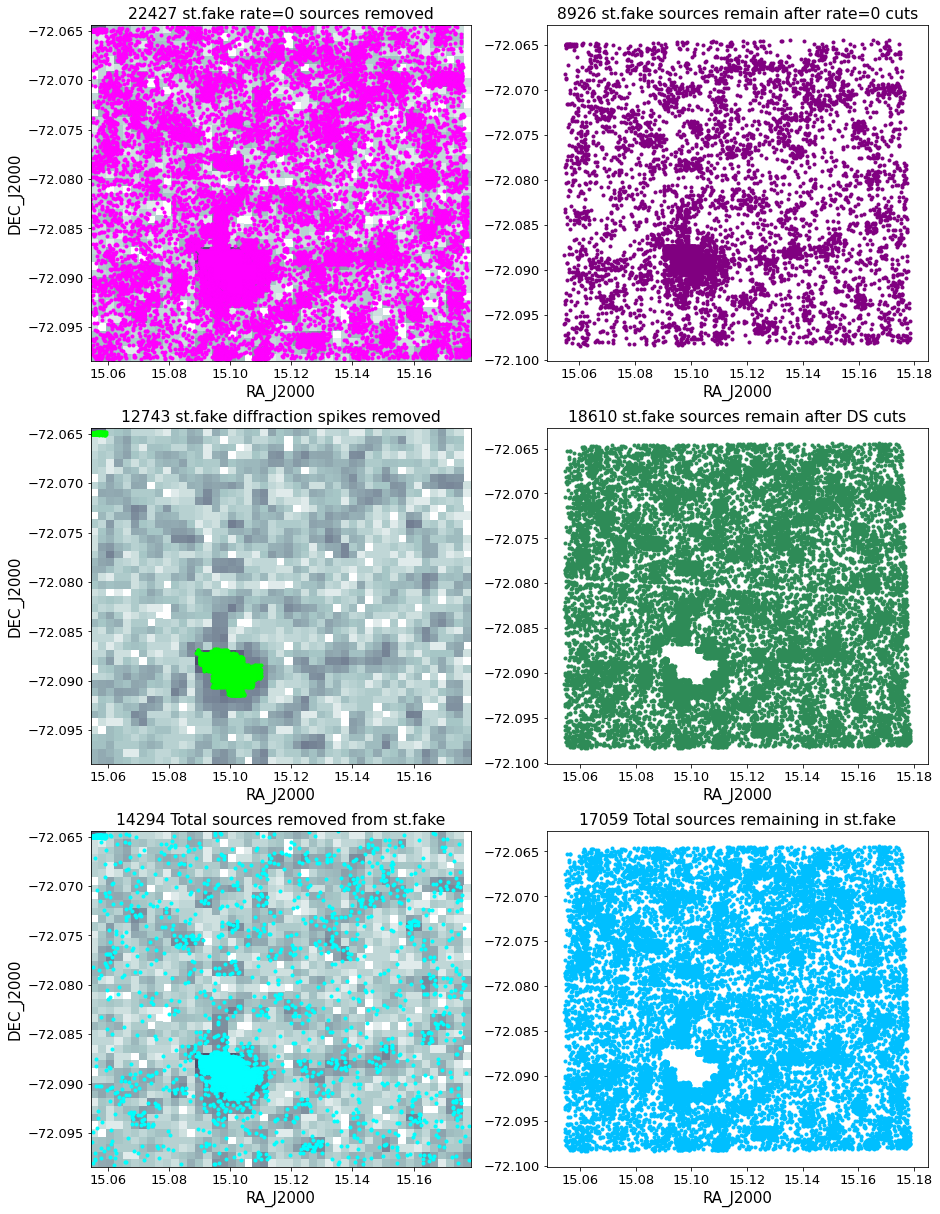

In [60]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

fig = plt.figure(figsize=(15,21))

# removed sources from rate=0 cuts on the st.fake catalog
plt.subplot(321)
h_fake = plt.hist2d(st_fake_t[ra_key_f], st_fake_t[dec_key_f], bins=nbins_f, norm=LogNorm())#, cmap=cmocean.cm.deep)
h_qual_cut = plt.plot(st_fake_t[ra_key_f][~rate_cut_fake], st_fake_t[dec_key_f][~rate_cut_fake], '.', c='magenta', ls='')
plt.xlabel(ra_key_f,fontsize=15)
plt.ylabel(dec_key_f,fontsize=15)
plt.title('%d st.fake rate=0 sources removed' % len(st_fake_t[~rate_cut_fake]))

# remaining sources from rate=0 cuts
plt.subplot(322)
h_qual = plt.plot(st_fake_t[ra_key_f][rate_cut_fake], st_fake_t[dec_key_f][rate_cut_fake], '.', c='purple', ls='')
plt.xlabel(ra_key_f,fontsize=15)
plt.title('%d st.fake sources remain after rate=0 cuts' % len(st_fake_t[rate_cut_fake]))

# removed sources from diffraction spikes cuts on the st.fake catalog
plt.subplot(323)
plt.hist2d(st_fake_t[ra_key_f], st_fake_t[dec_key_f], bins=nbins_f, norm=LogNorm())#, cmap=cmocean.cm.deep)
h_ds_cut = plt.plot(st_fake_t[ra_key_f][~diff_flag_fake], st_fake_t[dec_key_f][~diff_flag_fake], '.', c='lime', ls='')
plt.xlabel(ra_key_f,fontsize=15)
plt.ylabel(dec_key_f,fontsize=15)
plt.title('%d st.fake diffraction spikes removed' % len(st_fake_t[~diff_flag_fake]))

# remaining sources from diffraction spikes cut
plt.subplot(324)
h_ds = plt.plot(st_fake_t[ra_key_f][diff_flag_fake], st_fake_t[dec_key_f][diff_flag_fake], '.', c='seagreen', ls='')
plt.xlabel(ra_key_f,fontsize=15)
plt.title('%d st.fake sources remain after DS cuts' % len_diff_flag_fake)

# removed sources from photometric quality cuts & medfilt diffraction spike cuts
plt.subplot(325)
plt.hist2d(st_fake_t[ra_key_f], st_fake_t[dec_key_f], bins=nbins_f, norm=LogNorm())#, cmap=cmocean.cm.deep)
h_qual = plt.plot(st_fake_t[ra_key_f][~final_cut_fake], st_fake_t[dec_key_f][~final_cut_fake], '.', c='aqua', ls='')
plt.xlabel(ra_key_f,fontsize=15)
plt.ylabel(dec_key_f,fontsize=15)
plt.title('%d Total sources removed from st.fake' % len(st_fake_t[~final_cut_fake]))

# remaining sources from photometric quality cuts & medfilt diffraction spike cuts
plt.subplot(326)
h_ds = plt.plot(st_fake_t[ra_key_f][final_cut_fake], st_fake_t[dec_key_f][final_cut_fake], '.', c='deepskyblue', ls='')
plt.xlabel(ra_key_f,fontsize=15)
plt.title('%d Total sources remaining in st.fake' % len_final_cut_fake)

if savefig:
    figname = outDir+'clean_st_3_catalog_%s_ks_%s_th_%s_crwd_%s_rnd_%s.png' % \
                (target, kernel_size, sd_thre_fake, crowd_th, round_th)
    plt.savefig(figname, dpi=200)
    print('st.fake cleaned catalogs saved as', figname)

cmd_st_sources = st_fake_t[two_key[0]+'_VEGA'] < 99
len_cmd_st_sources = len(st_fake_t[cmd_st_sources])

In [189]:
# NOT SURE THIS CODE IS NEEDED, SEEMS TO BE A REPEAT

# st_cut_flag = Table.read('/Users/pyanchulova/Downloads/15891_SMC-3956ne-9632.st.fake.fits')

# f336nan_fake = np.isnan(st_cut_flag['F336W_IN'])
# print('N (F336W_IN = NaN):', len(st_cut_flag[f336nan_fake])) # N=9574
# st_cut_flag["F336W_IN"][f336nan_fake] = 99

# # Check if st.fake has CUT_FLAG colum. If not, create it.
# if "CUT_FLAG" not in st_cut_flag.colnames:
#     print("Adding a CUT_FLAG")
#     st_cut_flag.add_column(np.ones(len(st_cut_flag), dtype=int), name="CUT_FLAG", index=-1)

# # making sure cut_flag=0 if multiple tests record 0s and 1s in catalog
# st_cut_flag["CUT_FLAG"] = 0

# st_cut_flag_file = '/Users/pyanchulova/Downloads/15891_SMC-3956ne-9632.st_with_cut_flag.fake.fits'
# st_cut_flag.write(st_cut_flag_file, overwrite=True)

N (F336W_IN = NaN): 9574
Adding a CUT_FLAG


## Calculate the area under the completeness curve

In [6]:
scylla_sed_grid = inDir + '15891_' + target + '_seds.grid.hd5'
print(scylla_sed_grid)
# cut sources should be flagged and read by the BEAST

/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_seds.grid.hd5


Fitting model: 100%|██████████| 6/6 [00:00<00:00, 27.63it/s]


HST_WFC3_F275W
HST_WFC3_F336W
HST_WFC3_F475W
HST_WFC3_F814W
HST_WFC3_F110W
HST_WFC3_F160W


Fitting model: 100%|██████████| 6/6 [00:00<00:00, 31.09it/s]


HST_WFC3_F275W
HST_WFC3_F336W
HST_WFC3_F475W
HST_WFC3_F814W
HST_WFC3_F110W
HST_WFC3_F160W


Fitting model: 100%|██████████| 6/6 [00:00<00:00, 29.19it/s]


HST_WFC3_F275W
HST_WFC3_F336W
HST_WFC3_F475W
HST_WFC3_F814W
HST_WFC3_F110W
HST_WFC3_F160W


Fitting model: 100%|██████████| 6/6 [00:00<00:00, 29.96it/s]


HST_WFC3_F275W
HST_WFC3_F336W
HST_WFC3_F475W
HST_WFC3_F814W
HST_WFC3_F110W
HST_WFC3_F160W


Fitting model: 100%|██████████| 6/6 [00:00<00:00, 31.66it/s]


HST_WFC3_F275W
HST_WFC3_F336W
HST_WFC3_F475W
HST_WFC3_F814W
HST_WFC3_F110W
HST_WFC3_F160W


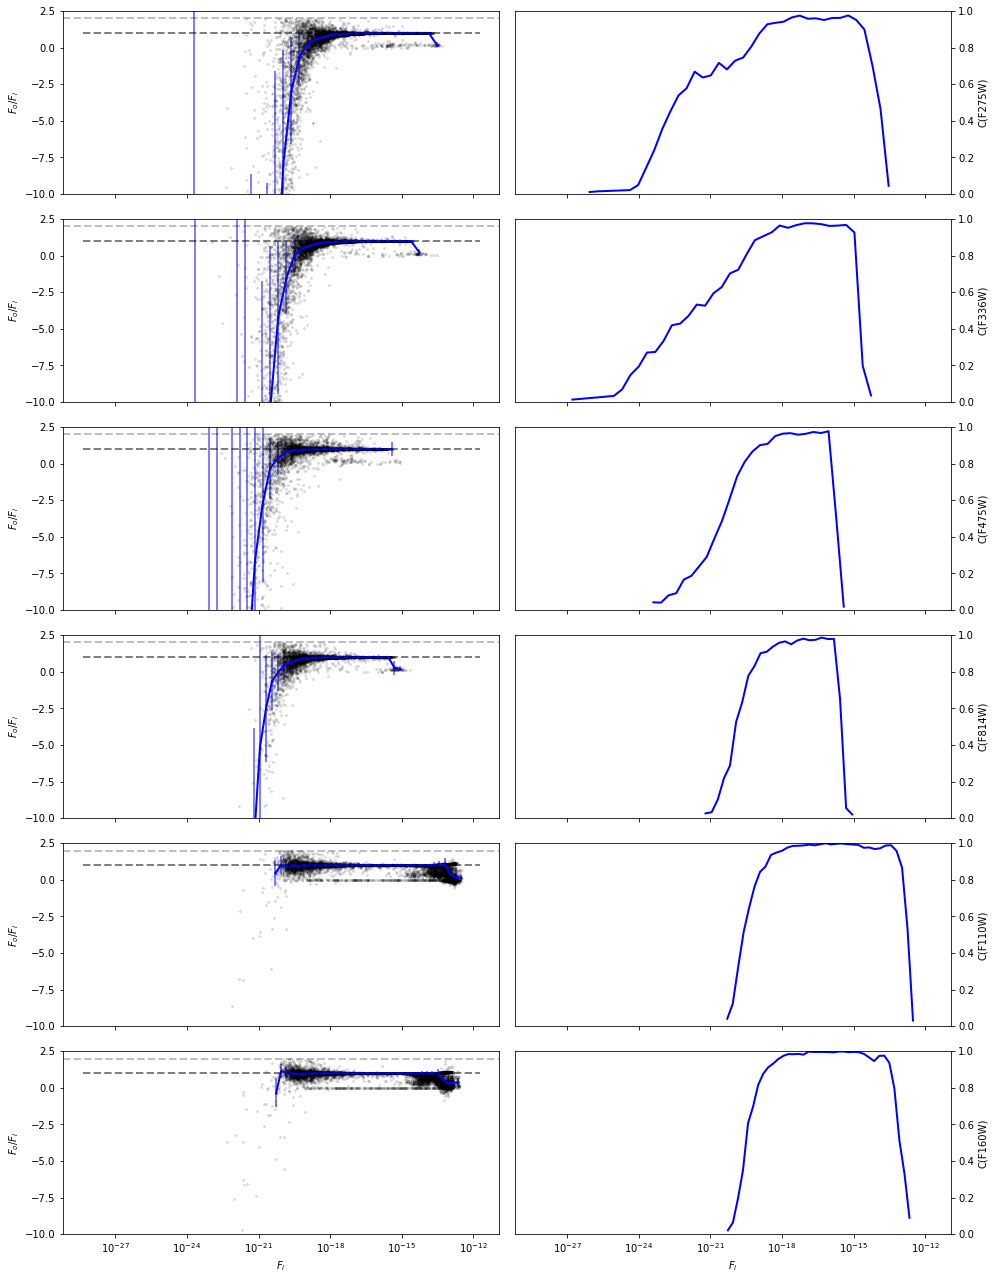

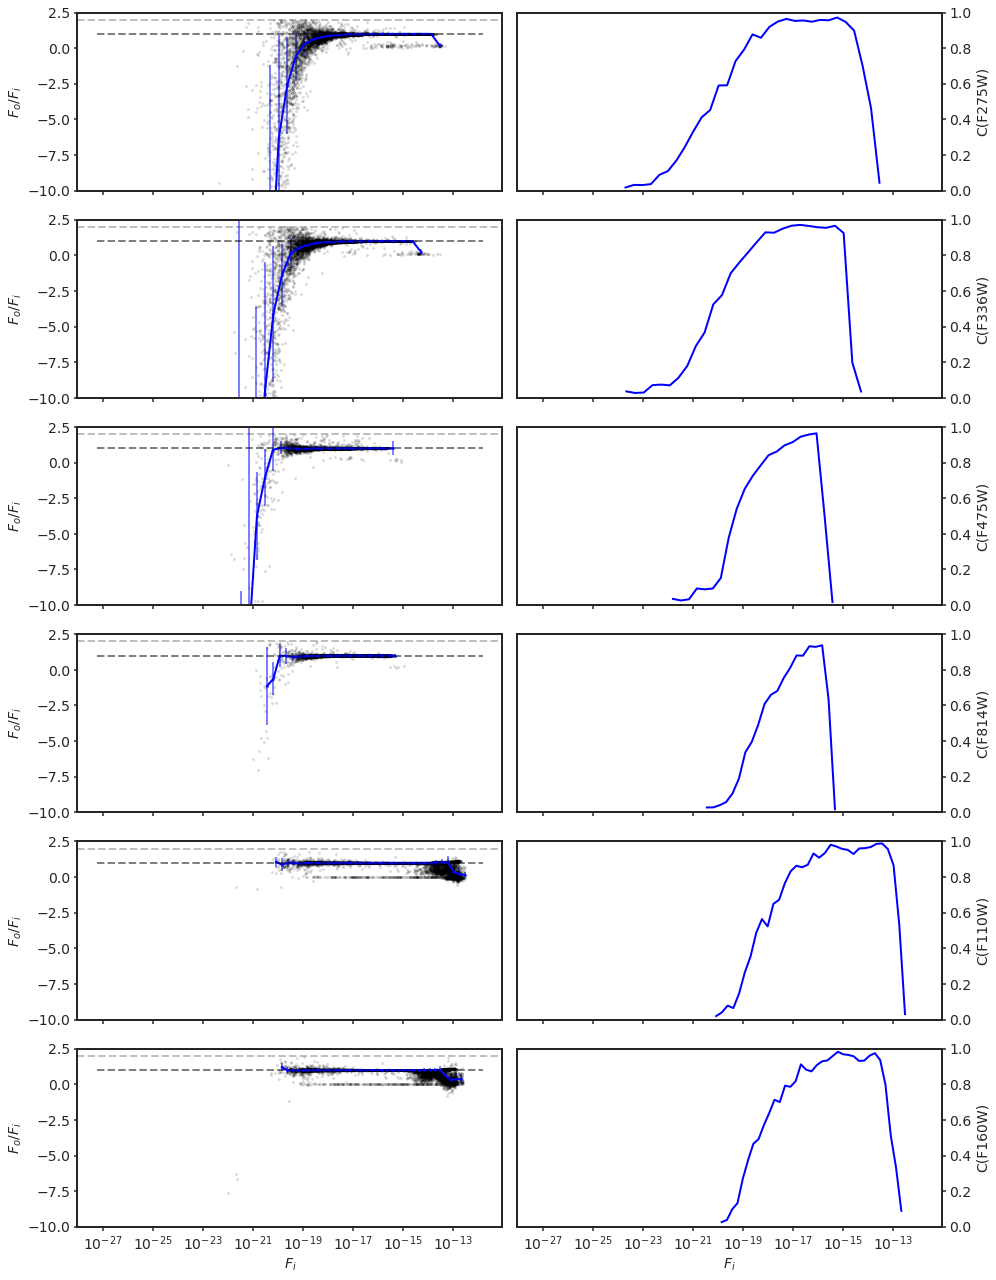

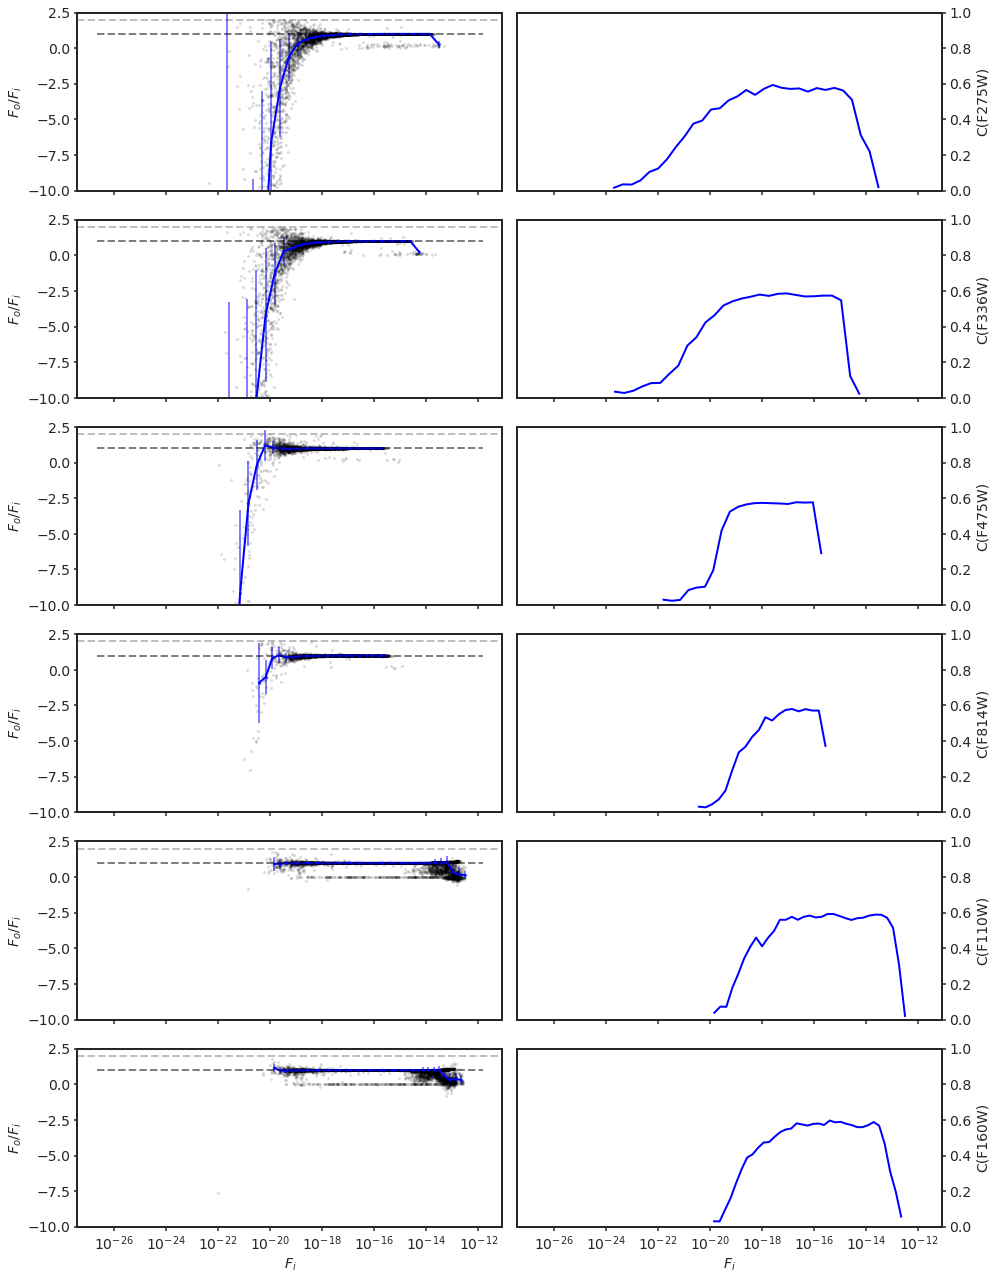

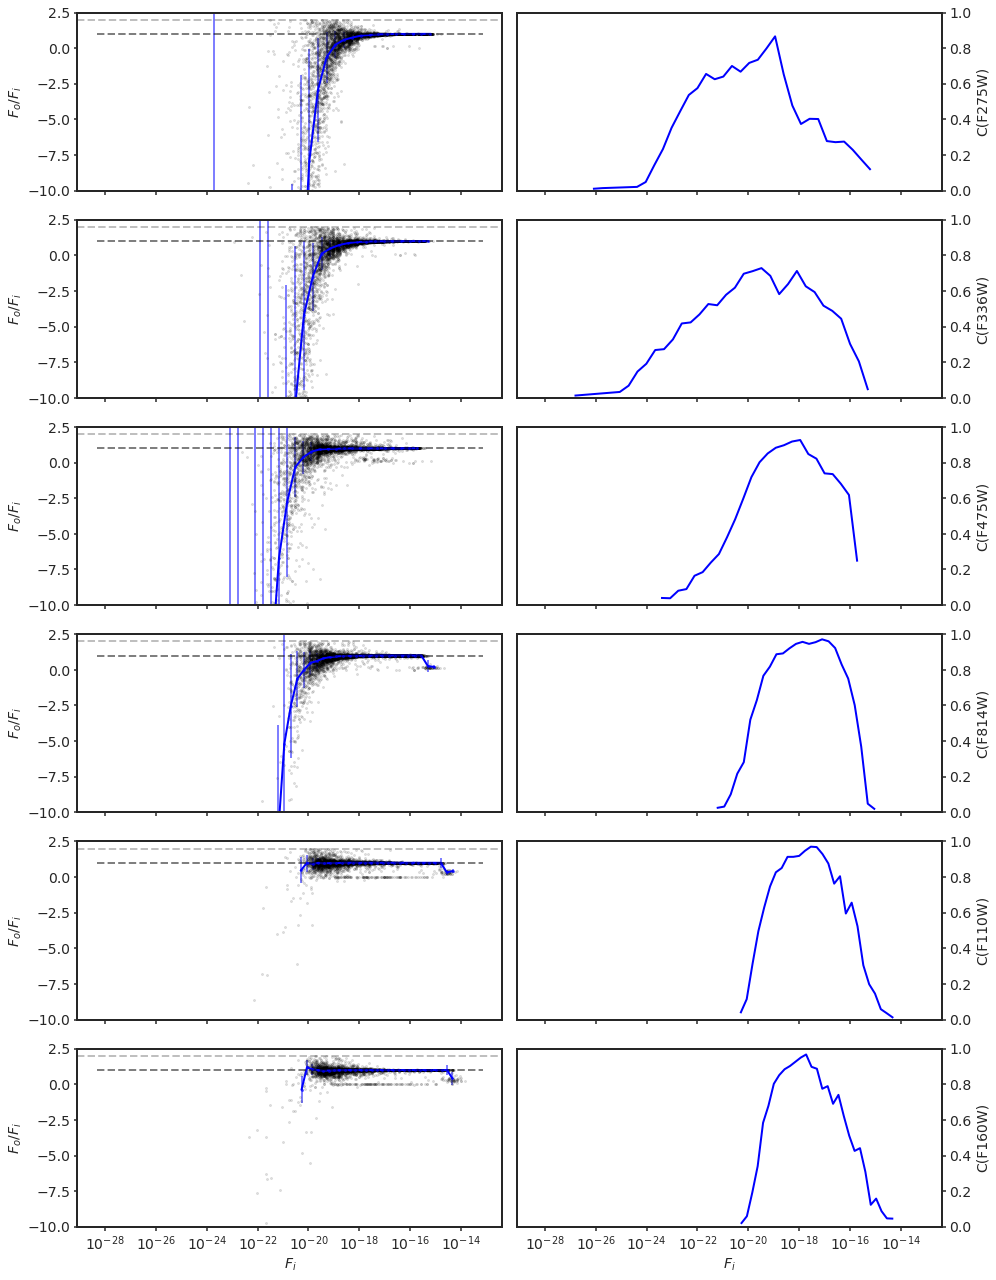

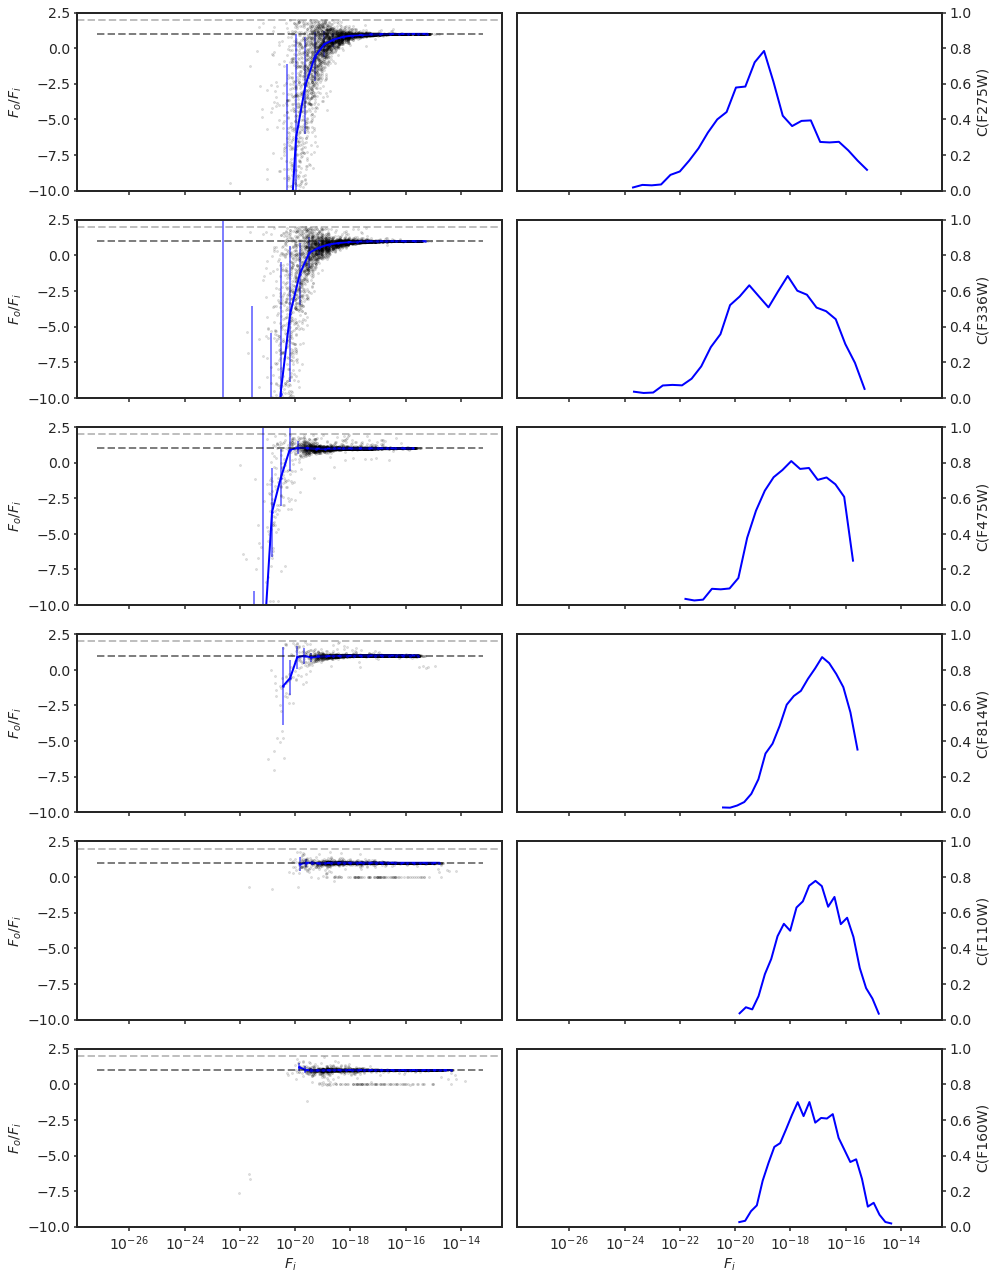

In [7]:
test_completeness = True
if test_completeness is True:
    outcat_fake_cut_flag_only = '/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_cut_flag_only_Ncut_0.fake.fits'
    st_fake_flag_cut_only = outcat_fake_cut_flag_only
    fluxes_f, compls_f = plot_toothpick_details.plot_toothpick_details(st_fake_flag_cut_only, scylla_sed_grid, savefig='png')
    
    # vgst cuts:
    outcat_fake_cut_phot_only = '/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_cut_phot_only_Ncut_3632.fake.fits'
    # gst cuts (crowd <= 2 mag, round <= 1 mag, sharp^2 <= 0.4 mag): 
    # outcat_fake_cut_phot_only = '/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_cut_phot_only_Ncut_2883.fake.fits'
    st_fake_phot_cut_only = outcat_fake_cut_phot_only
    fluxes_p, compls_p = plot_toothpick_details.plot_toothpick_details(st_fake_phot_cut_only, scylla_sed_grid, savefig='png')

    outcat_fake_cut_phot_w_medfilt_only = '/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_cut_phot_w_medfilt_only_Ncut_2883.fake.fits'
    st_fake_phot_medfilt_cut_only = outcat_fake_cut_phot_w_medfilt_only
    fluxes_pmf, compls_pmf = plot_toothpick_details.plot_toothpick_details(st_fake_phot_medfilt_cut_only, scylla_sed_grid, savefig='png')
    
    outcat_fake_cut_rate_only = '/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_cut_rate_zero_only_Ncut_22427.fake.fits'
    st_fake_rate_cut_only = outcat_fake_cut_rate_only
    fluxes_r, compls_r = plot_toothpick_details.plot_toothpick_details(st_fake_rate_cut_only, scylla_sed_grid, savefig='png')

    outcat_fake_cut_phot_and_rate = '/Users/pyanchulova/Documents/scylla/15891_SMC-3370ne-13459_cut_both_photqual_and_ratezero_Ncut_25942.fake.fits'
    st_fake_phot_and_rate_cut = outcat_fake_cut_phot_and_rate
    fluxes_pr, compls_pr = plot_toothpick_details.plot_toothpick_details(st_fake_phot_and_rate_cut, scylla_sed_grid, savefig='png')

else:
    #st_fake_orig = '../Downloads/15891_SMC-3956ne-9632.st_with_cut_flag.fake.fits'
    st_fake_in = 'scylla/15891_SMC-3956ne-9632_cut_rate_zero_only_Ncut_108156.fake.fits'
    fluxes, compls = plot_toothpick_details.plot_toothpick_details(st_fake_in, scylla_sed_grid, savefig='png')

## Calculate completeness curve area; source density to completeness ratio

In [8]:
if test_completeness:
    compls_sums_f = [sum(x) for x in compls_f]
    compls_sums_p = [sum(x) for x in compls_p]
    compls_sums_pmf = [sum(x) for x in compls_pmf]
    compls_sums_r = [sum(x) for x in compls_r]
    compls_sums_pr = [sum(x) for x in compls_pr]
    print(compls_sums_f)
    print(compls_sums_p)
    print(compls_sums_pmf)
    print(compls_sums_r)
    print(compls_sums_pr)
else:
    compls_sums = [sum(x) for x in compls]
    src_den_to_comp_sum = [x / src_den_range for x in compls_sums]

[22.48292130307171, 19.75017804147711, 15.092541910074413, 16.626592887644183, 29.103904041683794, 29.81681434639378]
[17.996975736531034, 15.262862693109058, 10.511597581495122, 10.399330800514266, 22.870348635505753, 23.65577148698693]
[11.710193660233662, 10.239934214814857, 7.505592009361187, 7.544100644366782, 14.978894754011748, 15.467965230323445]
[12.4496313763477, 12.863725801555805, 13.28021132700225, 15.371507030404974, 15.558054452708564, 15.714731534731097]
[8.064556639921665, 8.480346510574408, 8.844211926303092, 9.239326710790307, 9.475287757247157, 9.73974505751456]


## Plot completeness stats: fraction cut / remaining; integrated completeness per filter

target: SMC-3370ne-13459
[1.0, 0.88, 0.5, 0.28, 0.16]


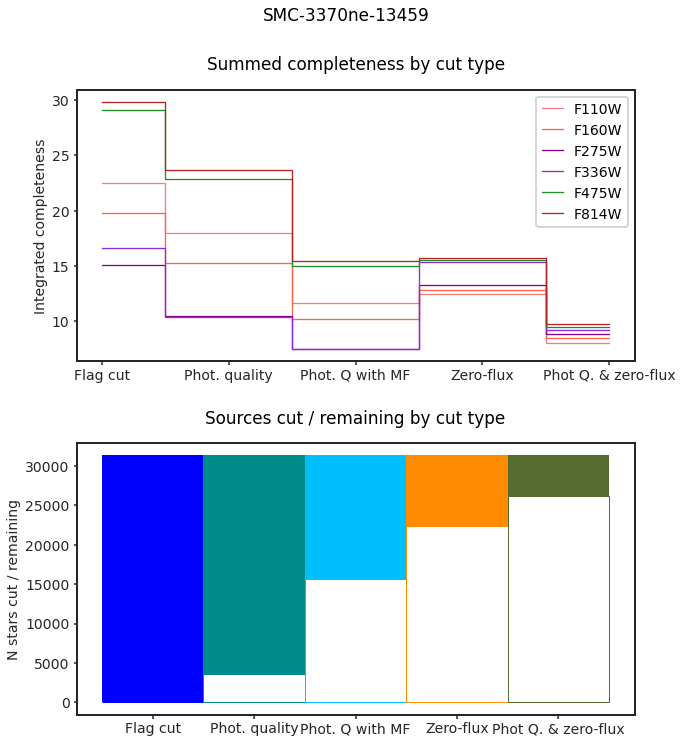

In [46]:
print('target:', target)
if test_completeness:
    len_pmf_cut = 15676
    len_pmf_stay = 15676
    stats_cut = [len_f_cut, len_p_cut, len_pmf_cut, len_r_cut, len_pr_cut]
    stats_stay = [len_f_stay, len_p_stay, len_pmf_stay, len_r_stay, len_pr_stay]
    stats_sum = [x+y for x,y in zip(stats_cut, stats_stay)]
    stats_fract = [np.around(x/y, decimals=2) for x,y in zip (stats_stay, stats_sum)]
    stats_percent = [np.around(x/y*100, decimals=1) for x,y in zip (stats_stay, stats_sum)]
    stats_text_ypos = [0.9 * x for x in stats_sum]
    print(stats_fract)
#     stats_cut_neg = np.negative(stats_cut)
    
#     filters = [x.split('_')[0] for x in t.colnames if "VEGA" in x]
    compls_all = [compls_sums_f, compls_sums_p, compls_sums_pmf, compls_sums_r, compls_sums_pr]
    filt_len = len(filters_fake)
    filt_ind = np.arange(0, filt_len, dtype=int)
    
    fig = plt.figure(figsize=(10,11.5))
    plt.suptitle('%s' % target)
    cut_type = ['Flag cut', 'Phot. quality', 'Phot. Q with MF', 'Zero-flux', 'Phot Q. & zero-flux']
    x_n = np.array([1, 2, 3, 4])
    cut_col = ['blue', 'darkcyan', 'deepskyblue', 'darkorange', 'darkolivegreen']
    filter_col = ['lightcoral', 'tomato', 'darkmagenta', 'blueviolet', 'forestgreen', 'firebrick']
    filter_col_start = 0 # change depending on which sequence of filters exist
    plt.subplot(211)
    
    # plot this way once code is ready
#     compls_per_filter = []
#     for i in range(len(compls_all)):
#         plt.step(cut_type, compls_all[i], color=filter_col[], lw=1.5, where='mid', label=filters_fake)

    compls_275 = [x[0] for x in compls_all]
    compls_336 = [x[1] for x in compls_all]
    compls_475 = [x[2] for x in compls_all]
    compls_814 = [x[3] for x in compls_all]
    compls_110 = [x[4] for x in compls_all]
    compls_160 = [x[5] for x in compls_all]
    compls_per_filter = [compls_275, compls_336, compls_475, compls_814, compls_110, compls_160]

    for i in range(len(filters_fake)):
        plt.step(cut_type, compls_per_filter[i], color=filter_col[i], 
                 lw=1.3, where='mid', label=filters_fake[i])
    plt.legend()
#     plt.hlines(0, xmin=-0.5,xmax=3.5, lw=1, color='w')
    ax1=plt.gca()
    ax1.set_ylabel('Integrated completeness')
    plt.title('Summed completeness by cut type', y=1.05)
    
    plt.subplot(212)
    plt.xticks = (x_n, cut_type)
    plt.bar(cut_type, stats_cut, ec=cut_col, width=1, lw=1, fill=False)
    plt.bar(cut_type, stats_stay, bottom = stats_cut, color=cut_col, width=1, fill=True)
#     [plt.text(x, y, '%s%%' % z, c='w') for x,y,z in zip(cut_type, stats_text_ypos, stats_percent)]
    ax2=plt.gca()
    ax2.set_ylabel('N stars cut / remaining')
    plt.title('Sources cut / remaining by cut type', y=1.05)
    plt.ylim(-0.05 * len(st_fake_t), 1.05 * len(st_fake_t))
    
    plt.subplots_adjust(hspace=0.3)
    
    plt.savefig(inDir + '15891_%s_completeness_by_cut.png' % target)

## Stats with fraction of removed / remaining sources; print area under completeness curve

In [292]:
print('Completeness sum in each filter:', compls_sums)
print('Completeness to source density ratio', src_den_to_comp_sum)

Completeness sum in each filter: [6.6212890142779655, 12.747539692572948, 13.211402266314813]
Completeness to source density ratio [0.057080077709292805, 0.10989258355666334, 0.1138913988475415]


## Check if global minimum; if so, replace previous minimum

In [65]:
if trials==1:
    global_maximum = [0.0, 0.0, 0.0]

for i in range(len(filters_fake)):
    if src_den_to_comp_sum[i] > global_maximum[i]:
        print('There is a new global maximum for %s!' % filters_fake[i])
        global_maximum[i] = src_den_to_comp_sum[i]

There is a new global maximum for F336W!
There is a new global maximum for F475W!
There is a new global maximum for F814W!


## Kernel Size vs Density Threshold

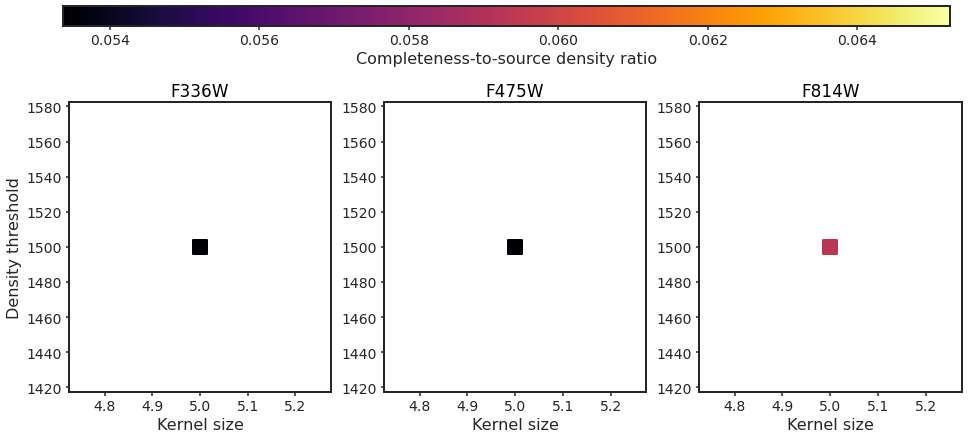

In [157]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,7))
cmap='inferno'

# Plot results for each filter
for j in range(trials):
    for i, ax in enumerate(axes.flat):
        sc = ax.scatter(grid_results_arr[j,i,1], grid_results_arr[j,i,2], c=grid_results_arr[j,i,0], marker='s', s=170, cmap=cmap)
        ax.set_xlabel('Kernel size', fontsize=16)
        if i==0:
            ax.set_ylabel('Density threshold', fontsize=16)
        ax.set_title('%s' % filters_fake[i])
    
fig.subplots_adjust(top=0.7) #to make space for the cbar
cbar_ax = fig.add_axes([0.12, 0.85, 0.77, 0.04])
cb = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='Completeness-to-source density ratio', size=16)

## Crowding vs Roundness

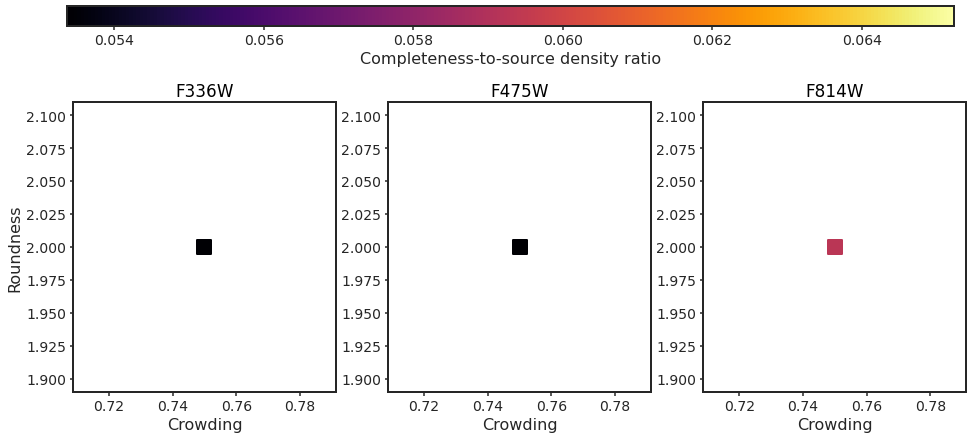

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,7))
cmap='inferno'

# Plot results for each filter
for j in range(trials):
    for i, ax in enumerate(axes.flat):
        sc = ax.scatter(grid_results_arr[j,i,3], grid_results_arr[j,i,4], c=grid_results_arr[j,i,0], marker='s', s=170, cmap=cmap)
        ax.set_xlabel('Crowding', fontsize=16)
        if i==0:
            ax.set_ylabel('Roundness', fontsize=16)
        ax.set_title('%s' % filters_fake[i])
    
fig.subplots_adjust(top=0.7) #to make space for the cbar
cbar_ax = fig.add_axes([0.12, 0.85, 0.77, 0.04])
cb = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='Completeness-to-source density ratio', size=16)

## Global Maximum:

In [159]:
print(global_maximum)

[0.03142628823144345, 0.055601705917979936, 0.05930621967926141]


## Grid Results

In [160]:
print(grid_results)

[array([[0.03142628823144345, 5, 1500, 0.75, 2, 0.2],
       [0.055601705917979936, 5, 1500, 0.75, 2, 0.2],
       [0.05930621967926141, 5, 1500, 0.75, 2, 0.2]], dtype=object), array([[0.023448999747652702, 5, 700, 0.75, 2, 0.2],
       [0.0426358316115782, 5, 700, 0.75, 2, 0.2],
       [0.04656070184208408, 5, 700, 0.75, 2, 0.2]], dtype=object), array([[0.023448999747652702, 5, 700, 0.75, 2, 0.2],
       [0.0426358316115782, 5, 700, 0.75, 2, 0.2],
       [0.04656070184208408, 5, 700, 0.75, 2, 0.2]], dtype=object)]
